### Introduction
#### Create a machine learning model to predict if the policyholder will file a claim in the next 6 months or not based on the set of car and policy features.

### Import the necessary packages

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # visualization
from matplotlib import pyplot as plt # visualization
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import re


from scipy.stats import skew, kurtosis


from sklearn.model_selection import  cross_val_score,KFold,train_test_split,ShuffleSplit,StratifiedKFold,learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,classification_report,confusion_matrix,log_loss,ConfusionMatrixDisplay,roc_curve,precision_recall_curve
from sklearn.preprocessing import LabelEncoder,StandardScaler,PolynomialFeatures
import math
import shap
shap.initjs()

### Import train and test dataset

In [3]:
train=pd.read_csv("/Users/mubeen/Library/CloudStorage/OneDrive-TheUniversityofHongKong/Year5/Chengdu/Risk Calculation/AV-Dataverse-Hack---Insurance-Claim-Prediction/data/train.csv")
test=pd.read_csv("/Users/mubeen/Library/CloudStorage/OneDrive-TheUniversityofHongKong/Year5/Chengdu/Risk Calculation/AV-Dataverse-Hack---Insurance-Claim-Prediction/data/test.csv")

### Function to pre-process the data

In [4]:
def pre_process(df):
    
    
     
    df['max_torque_nm']=df['max_torque'].str.extract('(\d+)Nm').astype('int')
    df['max_torque_rpm']=df['max_torque'].str.extract('@(\d+)rpm').astype('int')
   
    df['max_power_bhp']=df['max_power'].str.extract('(\d+.\d+)bhp').astype('float')
    df['max_power_rpm']=df['max_power'].str.extract('@(\d+)rpm').astype('int')
    
    df['engine']=round(df['displacement']/1000,1) 
    
    
    
    car_brand={'F8D Petrol Engine':'maruti',
              '1.5 L U2 CRDi':'hyundai',
              'K Series Dual jet':'maruti',
              'K10C':'maruti',
              '1.2 L K Series Engine':'maruti',
              '1.0 SCe':'renault',
               'i-DTEC':'honda',
              '1.5 Turbocharged Revotorq':'tata',
              'G12B':'maruti',
              '1.2 L K12N Dualjet':'maruti',
              '1.5 Turbocharged Revotron':'tata'}
   
    df['car_brand']=df['engine_type'].map(car_brand)

    
    binary_col=[ 'is_esc', 'is_adjustable_steering', 'is_tpms', 'is_parking_sensors',
       'is_parking_camera','is_front_fog_lights',
       'is_rear_window_wiper', 'is_rear_window_washer',
       'is_rear_window_defogger', 'is_brake_assist', 'is_power_door_locks',
       'is_central_locking', 'is_power_steering',
       'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror',
       'is_ecw', 'is_speed_alert']
    
    binary_map={'Yes':1,'No':0}
    
    for col in binary_col:
        df[col]=df[col].map(binary_map)
        df[col]=df[col].astype('int')
        
    
    
    # Create a list of categorical feature names in the data
    grp_cols= ['make', 'segment', 'model',
               'fuel_type',
              'rear_brakes_type', 'engine', 'cylinder',
               'transmission_type', 'gear_box', 'steering_type',
               'car_brand']
    
    df['population_density_min'] = df.groupby('area_cluster')['population_density'].transform('min')
    df['population_density_max'] = df.groupby('area_cluster')['population_density'].transform('max')
    df['population_density_mean'] = df.groupby('area_cluster')['population_density'].transform('mean')
    df['population_density_median'] = df.groupby('area_cluster')['population_density'].transform('median')
        
    df=df.drop(columns=['max_torque','max_power','displacement'],axis=1)     
        
    
    """
    # Create a function to get a categorical columns percentage 
    def feat_perc(df):
        def group_by_perc(df,grp,target,extra=None):
            if not extra:
                df1=df.groupby([grp,target])[target].agg({'count'}).reset_index()
                df1=df1.assign(total=lambda x: x.groupby([grp])['count'].transform('sum')).assign(percentage=lambda x:x['count']/x['total'])
                df1=(df1.rename(columns={c:grp+'_'+target+'_'+c for c in df1.loc[:,df1.columns.str.
                                                            match("(percentage|total|count)")]}))
                #df1=df1.drop(columns=['total','count'])
                df2=pd.pivot_table(df1, 
                       values=[grp+'_'+target+'_percentage',\
                               grp+'_'+target+'_count',\
                               grp+'_'+target+'_total'], index=[grp],\
                            columns=[target]).reset_index().melt(id_vars =\
                            [grp],var_name=['cat',target]).assign(n=lambda\
                          x: x['cat'].astype('str')+'_'+x[target].astype('str')).\
                            pivot_table(index=grp,columns='n',values='value').reset_index()
               
                return df1

            else:
                df1=df.groupby([extra,grp,target])[target].agg({'count'}).reset_index()
                df1=df1.assign(total=lambda x: x.groupby([extra, grp])['count'].transform('sum')).assign(percentage=lambda x:x['count']/x['total'])
                df1=(df1.rename(columns={c:extra+'_'+grp+'_'+target+'_'+c for c in df1.loc[:,df1.columns.str.
                                                        match("(count|total|percentage)")]}))
                #df1=df1.drop(columns=[target,'total','count'])
                df2=pd.pivot_table(df1, \
                       values=[extra+'_'+grp+'_'+target+'_percentage',\
                       extra+'_'+grp+'_'+target+'_count',\
                       extra+'_'+grp+'_'+target+'_total'], index=[extra,grp],\
                        columns=[target]).reset_index().melt(id_vars =\
                        [extra,grp],var_name=['cat','outcome']).\
                        assign(n=lambda x: x['cat'].astype('str')+'_'+x['outcome'].\
                        astype('str')).pivot_table(index=[extra,grp],columns='n',\
                                                   values='value').reset_index()
                return df2
        
        for col in ['make', 'segment', 'model',
               'fuel_type',
              'rear_brakes_type', 'engine', 'cylinder','engine_type','engine',
               'transmission_type', 'gear_box', 'steering_type',
               'car_brand']:
            df=pd.merge(df,group_by_perc(df,col,'is_claim'),on=['id',col],how='left')
           
            
        return df  
        
    
    # Apply the function to data
   # df=feat_perc(df)
   """     
        
    
    # Create a list of numerical feature names in the data
    numcols= ['policy_tenure', 'age_of_car', 'age_of_policyholder']
   
    
    
    # Function to get groupby numerical summary
    def feature_eng(df,types=None):
        if types is 'type1':
            for grp in grp_cols:
                for valcol in numcols:
                    df1=(df.groupby([grp])[valcol].
                     agg({'min','median','mean','max'}).reset_index())
                    df1=(df1.rename(columns={c:grp+'_'+valcol+'_'+c for c in df1.loc[:,df1.columns.str.
                                                    match("(min|median|mean|max)")]}))
                    df=pd.merge(df,df1,on=[grp],how='left')
            return df
        else:
            for valcol in numcols:
                df1=(df.groupby([grp_cols])[valcol].
                     agg({'min','median','mean','max'}).reset_index())
                df1=(df1.rename(columns={c:'grp_'+valcol+'_'+c for c in df1.loc[:,df1.columns.str.
                                                    match("(min|median|mean|max)")]}))
                df=pd.merge(df,df1,on=[grp_cols],how='left')
            return df
            


    # Apply the function data
    df=feature_eng(df,types='type1')
  
    
    """
    for valcol in numcols:
        df[f"group_{valcol}_kurtosis"]=(df.groupby(grp_cols)[valcol].
                                      transform(pd.Series.kurtosis))
        df[f"group_{valcol}_skew"]=(df.groupby(grp_cols)[valcol].
                                      transform(pd.Series.skew))
    
    #df=df.fillna(0)
    """
    
    #z-score outlier detection for numerical columns  
    def outlier_z(df,x):
        threshold = 3
        out=[]
        mean = np.mean(df[x])
        std = np.std(df[x])
        for i in df[x]:
            if ((i-mean)/std) > threshold:
                out.append(1)
            else:
                out.append(0)
        return out
    
    for col in numcols:
        df[f"{col}_outlier"]= outlier_z(df,col)
     
    #df[f"credit_score_outlier"]= outlier_z(df,'credit_score')
    #df['credit_score']=power_transform(df[['credit_score']], method='box-cox')
    #df['annual_mileage']=power_transform(df[['annual_mileage']], method='box-cox')
    
    # Return the dataframe
    
    return df 
    

### Apply the pre_process function to train data

In [5]:
train=pre_process(train)

In [6]:
for i,col  in enumerate(train.columns.values):
    print(f"{i}_{col}")

0_policy_id
1_policy_tenure
2_age_of_car
3_age_of_policyholder
4_area_cluster
5_population_density
6_make
7_segment
8_model
9_fuel_type
10_engine_type
11_airbags
12_is_esc
13_is_adjustable_steering
14_is_tpms
15_is_parking_sensors
16_is_parking_camera
17_rear_brakes_type
18_cylinder
19_transmission_type
20_gear_box
21_steering_type
22_turning_radius
23_length
24_width
25_height
26_gross_weight
27_is_front_fog_lights
28_is_rear_window_wiper
29_is_rear_window_washer
30_is_rear_window_defogger
31_is_brake_assist
32_is_power_door_locks
33_is_central_locking
34_is_power_steering
35_is_driver_seat_height_adjustable
36_is_day_night_rear_view_mirror
37_is_ecw
38_is_speed_alert
39_ncap_rating
40_is_claim
41_max_torque_nm
42_max_torque_rpm
43_max_power_bhp
44_max_power_rpm
45_engine
46_car_brand
47_population_density_min
48_population_density_max
49_population_density_mean
50_population_density_median
51_make_policy_tenure_median
52_make_policy_tenure_mean
53_make_policy_tenure_max
54_make_polic

### Split predictor and response variable.

In [7]:
X=train.iloc[:,np.r_[1:40,41:186]]
y=train['is_claim']

### Using label encoder encode the categorical columns into numeric

In [8]:
categorical_columns=list(X.select_dtypes(include='object').columns)

In [9]:
lbl=LabelEncoder()
for col in categorical_columns:
    X[col]=lbl.fit_transform(X[[col]])
    

### Split the train data for train and validation.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=43,stratify=y,
    shuffle=True)

### Train Randomforest classifier

In [11]:
clf_rf=RandomForestClassifier(max_depth=6,random_state=42)

In [12]:
clf_rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=6, random_state=42)

In [13]:
clf_rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [14]:
feat_import=pd.DataFrame({'column_name':clf_rf.feature_names_in_,'score':clf_rf.feature_importances_})

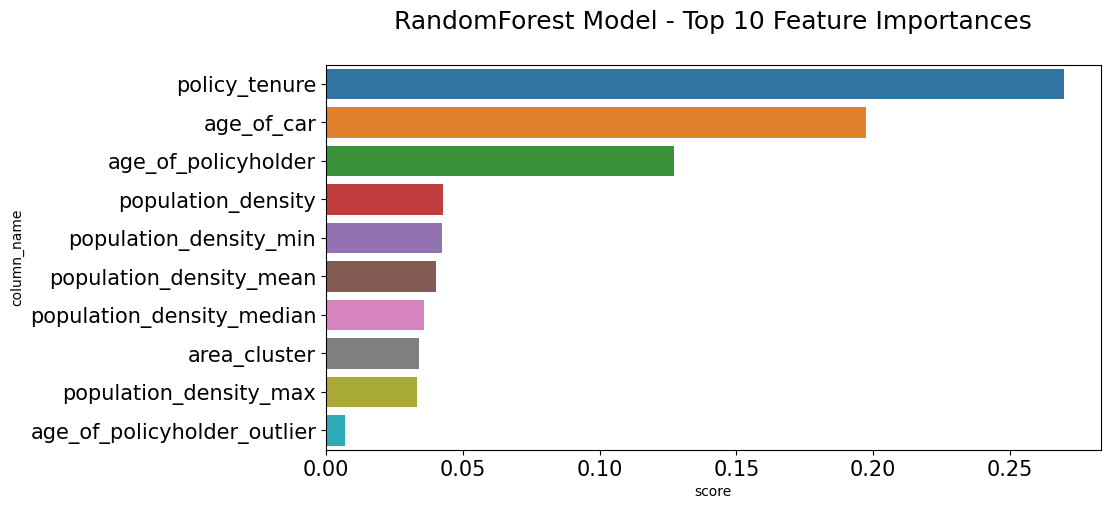

In [15]:
_=plt.figure(figsize=(10,5))
feat_import.nlargest(10,'score')
sns.barplot(data=feat_import.nlargest(10,'score'),
           x='score',y='column_name');
_=plt.yticks(fontsize=15)
_=plt.xticks(fontsize=15)
_=plt.title("RandomForest Model - Top 10 Feature Importances\n",fontsize=18)


### Interpret model with SHAP

In [16]:
explainer = shap.TreeExplainer(clf_rf)
shap_values = explainer.shap_values(X_train, y_train)

### Feature importances plot

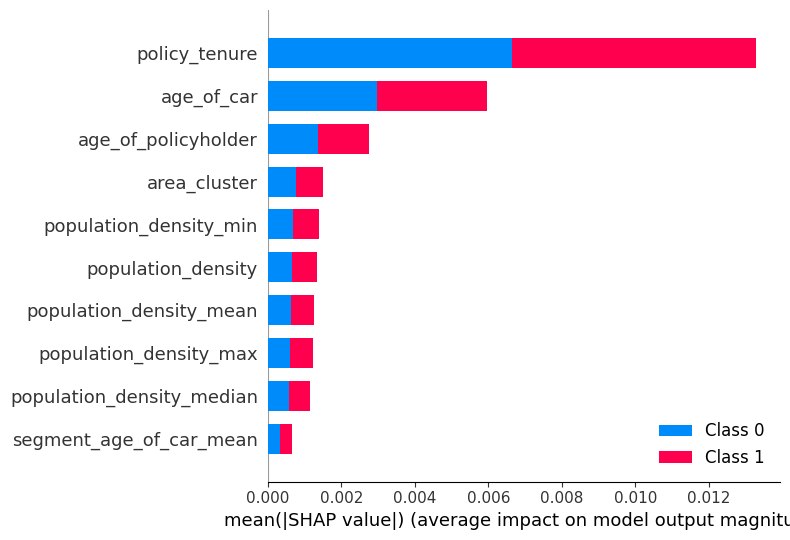

In [17]:
shap.summary_plot(shap_values, X_train, plot_type="bar",
                  max_display=10)

### Let's see which feature influences the model prediction for a single observation in each class.

### Top feature influences for class 0 

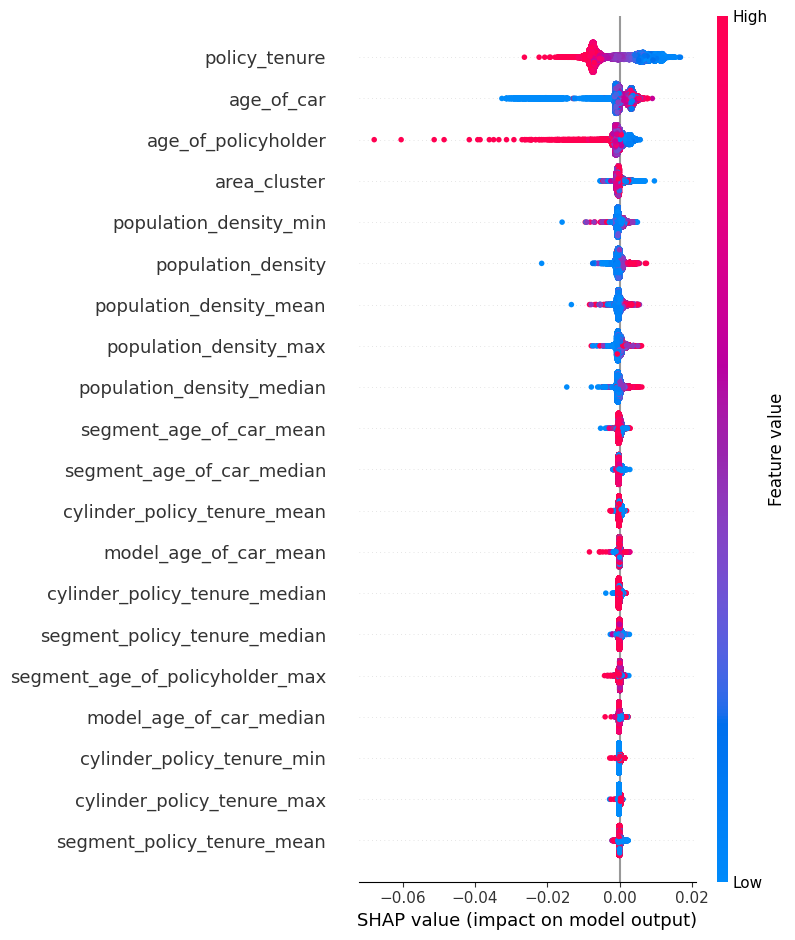

In [18]:
shap.summary_plot(shap_values[0], X_train)

### Top feature influences for class 1

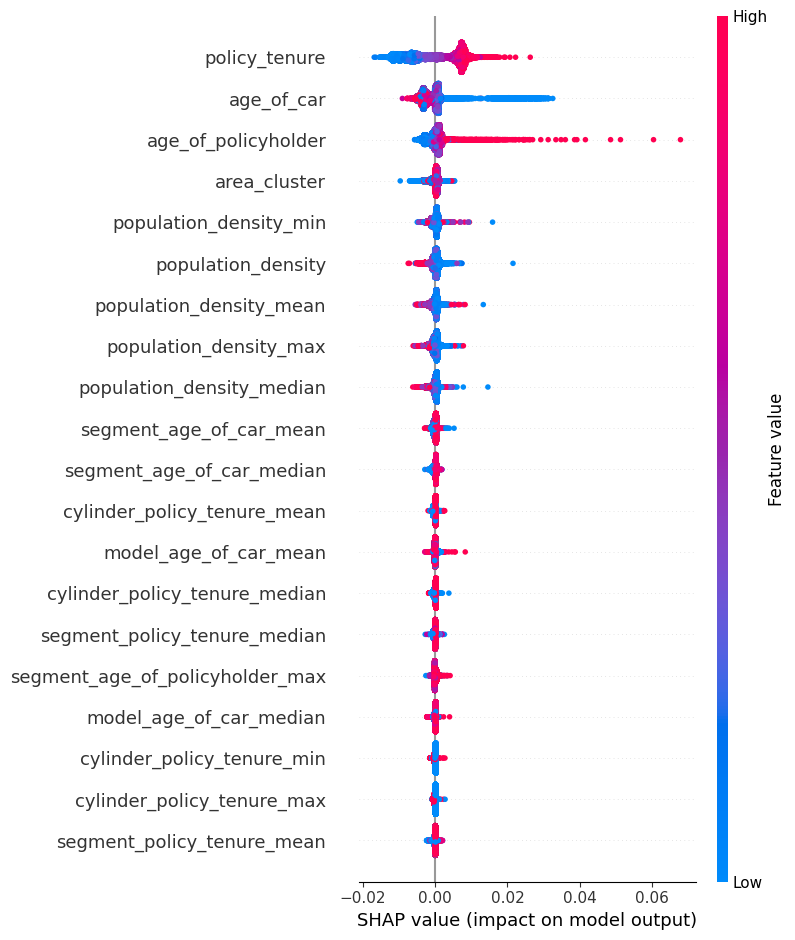

In [19]:
shap.summary_plot(shap_values[1], X_train)

### The postive class(1) has very low samples.Let's find the better threshold instead of deafault model threshold(0.5).
### Let's find the right threshold by using geometric mean(youden index), precision recall cut-off method, and threshold tuning method. 

### Predict the validation data probability and find the threshold.

In [20]:
val_pred=clf_rf.predict_proba(X_test)[:,1]

In [21]:
def optimal_threshold(y_true,y_prediction,types='',model='Your Model'):
    if types == 'gmean':
        fpr, tpr, thresholds = roc_curve(y_true, y_prediction)
        gmeans = np.sqrt(tpr * (1-fpr))
        # locate the index of the largest g-mean
        ix = np.argmax(gmeans)
        # plot the roc curve for the model

        fig, (thresh_plot,conf) = plt.subplots(2,1,figsize=(12,8),tight_layout=True)
                                              
        thresh_plot.plot([0,1], [0,1], linestyle='--', label='No Skill')
        thresh_plot.plot(fpr, tpr, marker='.', markersize=1,label=model)
        thresh_plot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label=f"Best:{thresholds[ix]:.5f}")
        #axis labels
        thresh_plot.set_xlabel('False Positive Rate')
        thresh_plot.set_ylabel('True Positive Rate')
        thresh_plot.set_title(f"Geometric Mean Threshold",fontsize=15)
        print(f"Geometric Mean Threshold - Best Threshold={thresholds[ix]:.5f}, G-Mean={gmeans[ix]:.5f}")
        thresh_plot.legend()
        y_pred_class=[1 if p>thresholds[ix] else 0 for p in y_prediction]
        clf_report = classification_report(y_true,
                                   y_pred_class,output_dict=True)
        #conf=display(pd.DataFrame(clf_report))
        tab=conf.table(cellText= np.round_(pd.DataFrame(clf_report).values,5),colLabels=pd.DataFrame(clf_report).columns,
                   rowLabels=['precision','recall','f1-score','support'],loc="center")
        conf.set_title("Confusion Matrix",fontsize=15)
        tab.auto_set_font_size(False)
        tab.set_fontsize(18)
        tab.scale(1.5,3)
        conf.grid(False)
        conf.axis('off')
        conf.set_xticks([])
        conf.set_yticks([])
        #conf.set_zticks([])
        # show the plot
        plt.show()
    elif types == "pr_re":
        precision, recall, thresholds = precision_recall_curve(y_true, y_prediction)
        fscore = (2 * precision * recall) / (precision + recall)
        # locate the index of the largest f score
        ix = np.argmax(fscore)
        no_skill = len(y_true[y_true==1]) / len(y_true)
        fig, (thresh_plot,conf) = plt.subplots(2,1,figsize=(12,8),tight_layout=True)
        thresh_plot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
        thresh_plot.plot(recall, precision, marker='.',markersize=1, label=model)
        thresh_plot.scatter(recall[ix], precision[ix], marker='o', color='black', label=f"Best:{thresholds[ix]:.5}")
        # axis labels
        thresh_plot.set_xlabel('Recall')
        thresh_plot.set_ylabel('Precision')
        thresh_plot.legend()
        thresh_plot.set_title(f"Threshold for Precision-Recall Curve",fontsize=15)
        print(f"Threshold for Precision-Recall Curve - Best Threshold={thresholds[ix]:.5f}, F-Score={fscore[ix]:.5f}")
        y_pred_class=[1 if p>thresholds[ix] else 0 for p in y_prediction]
        clf_report = classification_report(y_true,
                                   y_pred_class,output_dict=True)
        tab=conf.table(cellText= np.round_(pd.DataFrame(clf_report).values,5),colLabels=pd.DataFrame(clf_report).columns,
                   rowLabels=['precision','recall','f1-score','support'],loc="center")
        tab.auto_set_font_size(False)
        tab.set_fontsize(18)
        tab.scale(1.5,3)
        conf.grid(False)
        conf.axis('off')
        conf.set_title("Confusion Matrix",fontsize=15)
        conf.set_xticks([])
        conf.set_yticks([])
        
        
        
        
        # show the plot
        plt.show()
    elif types == 'tune':
        def to_class_label(probs, threshold):
            """convert predicted probabilities to class labels"""
            return (probs >= threshold).astype('int')

        def get_optimal_threshold(y_true, y_prediction):
            """Threshold tuning"""
            thresholds = np.arange(0, 1, 0.0001)
            #y_hat = fitted_model.predict_proba(x_test)
            #pos_clas_probs = y_hat[:, 1]
            f1_scores = [f1_score(y_true, to_class_label(y_prediction, thres)) for thres in thresholds]
            idx = np.argmax(f1_scores)
            return idx,f1_scores,thresholds[idx]
        
        score,list_score,opt_thres = get_optimal_threshold(y_true, y_prediction)
        print(f'Probability Threshold Tuning - Optimal threshold: {opt_thres:.4f}, F1-score: {list_score[score]:.5f}')
        fig, (thresh_plot,conf) = plt.subplots(2,1,figsize=(12,8),tight_layout=True)
        thresh_plot.plot([0,1], [0,1], linestyle='--', label='No Skill')
        thresh_plot.plot(np.arange(0, 1, 0.0001), list_score,marker='.',markersize=1,label=model)
        thresh_plot.scatter(np.arange(0, 1, 0.0001)[score], list_score[score], marker='o', color='black', label=f"Best: {opt_thres:.5f}")
        thresh_plot.set_title(f"Probability Threshold Tuning",fontsize=15)
        thresh_plot.set_xlabel('Probability Threshold')
        thresh_plot.set_ylabel('F1-Score')
        thresh_plot.legend()
        y_pred_class=[1 if p>opt_thres else 0 for p in y_prediction]
        clf_report = classification_report(y_true,
                                   y_pred_class,output_dict=True)
        tab=conf.table(cellText= np.round_(pd.DataFrame(clf_report).values,5),colLabels=pd.DataFrame(clf_report).columns,
                   rowLabels=['precision','recall','f1-score','support'],loc="center")
        tab.auto_set_font_size(False)
        tab.set_fontsize(18)
        tab.scale(1.5,3)
        conf.grid(False)
        conf.set_title("Confusion Matrix",fontsize=15)
        conf.axis('off')
        conf.set_xticks([])
        conf.set_yticks([])
        
        
        plt.show()
        #plt.plot(np.arange(0, 1, 0.0005), , marker='.', label='Logistic')
        #plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
        

Geometric Mean Threshold - Best Threshold=0.06871, G-Mean=0.60629


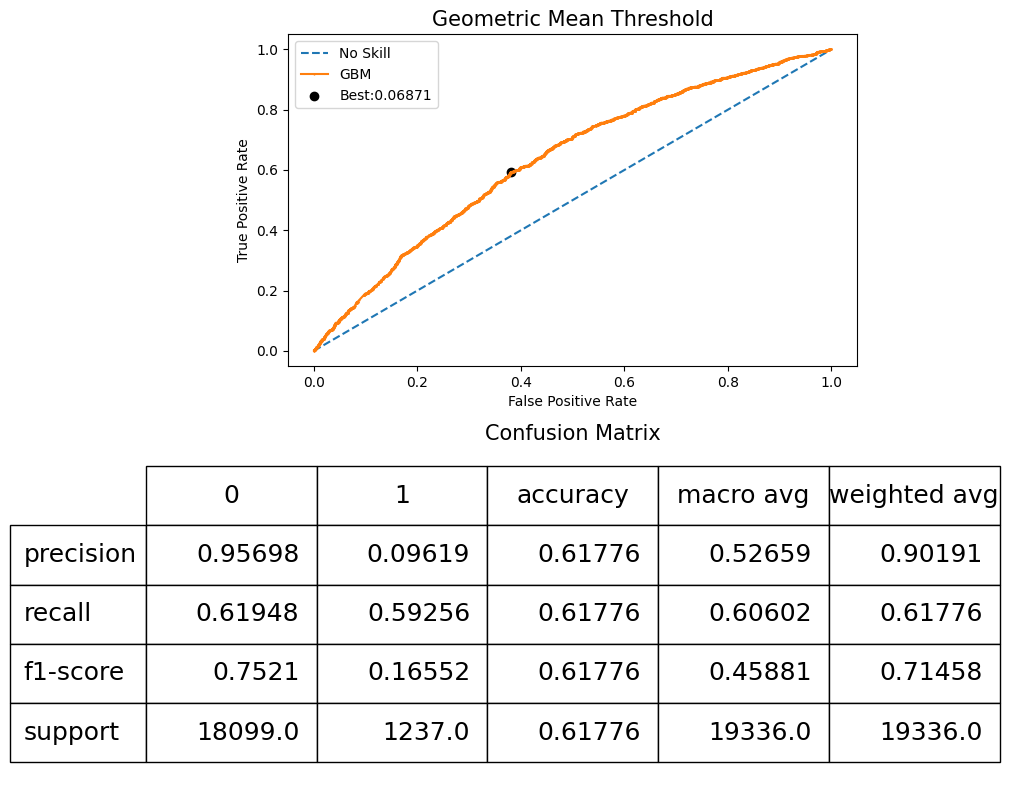

____________________________________________________________________________________________________
Threshold for Precision-Recall Curve - Best Threshold=0.18571, F-Score=nan


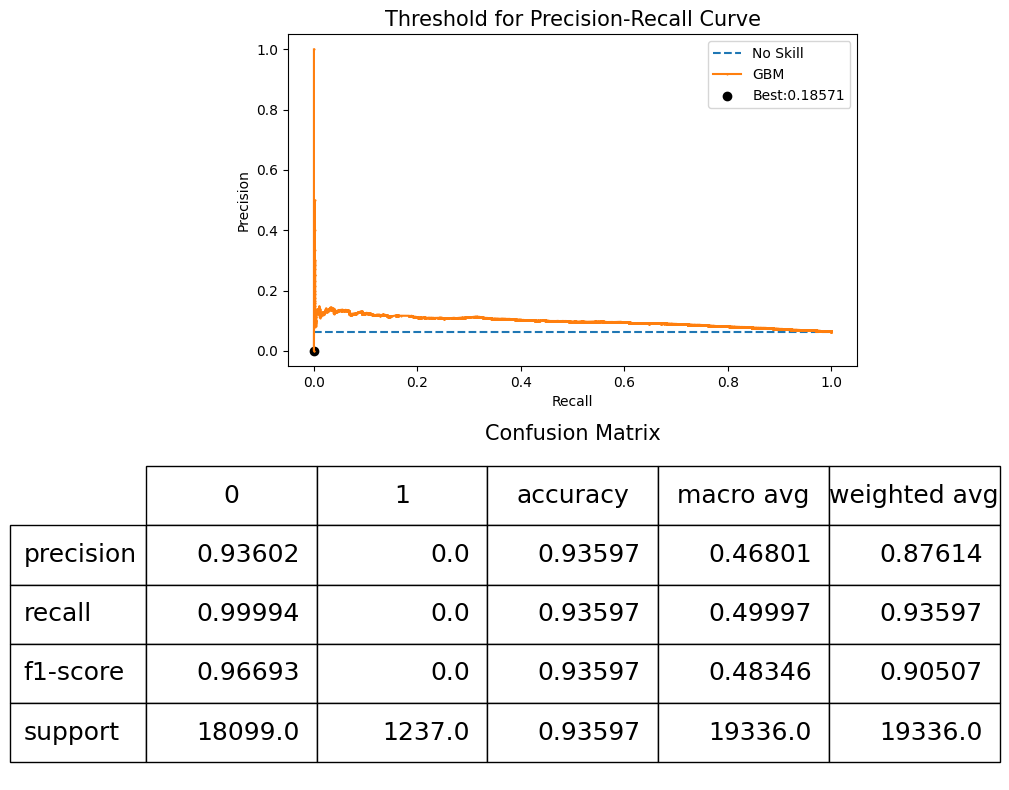

____________________________________________________________________________________________________
Probability Threshold Tuning - Optimal threshold: 0.0777, F1-score: 0.16670


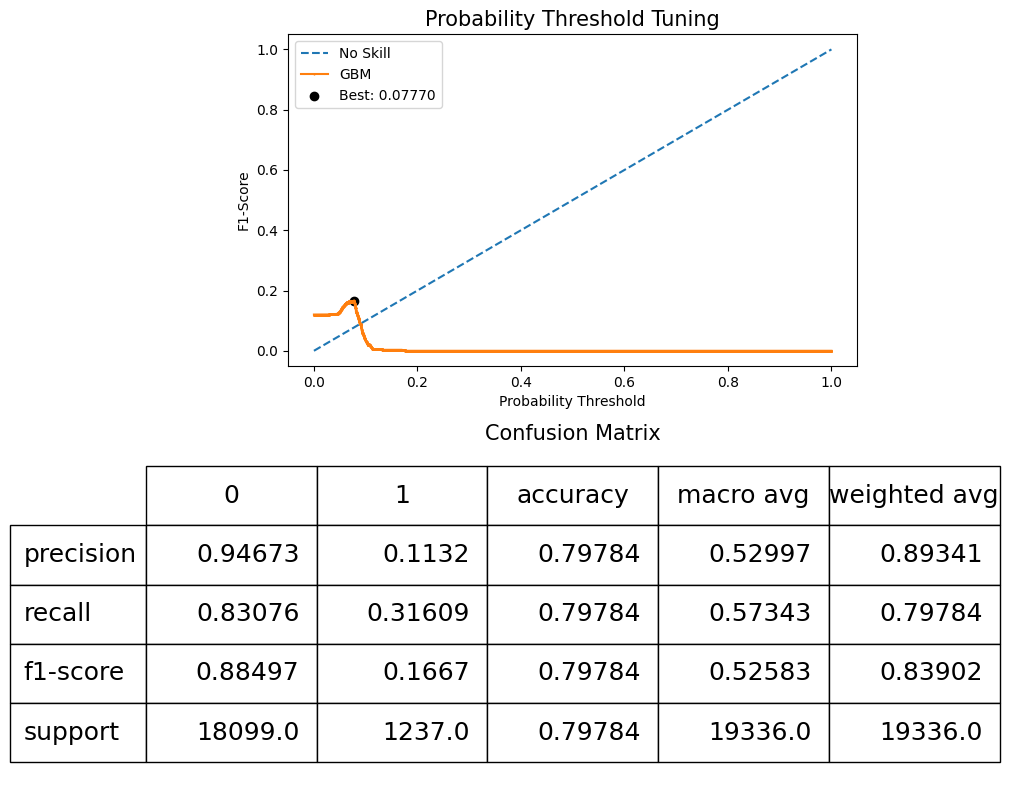

____________________________________________________________________________________________________


In [22]:
for i,col  in enumerate( ['gmean','pr_re','tune']):
    #print("="*100)
    _=optimal_threshold(y_test,val_pred,types=col,model='GBM')
    print("_"*100)
plt.show();

#### From the above plot and summary, the threshold tuning method performs better and gives good f1 score for class 1.Let's use same threshold for the new data prediction.

### Predict the new data

### Apply the pre-process function to test data

In [24]:
test=pre_process(test)

### Using label encoder encode the categorical columns into numeric

In [33]:
lbl=LabelEncoder()
for col in categorical_columns:
    test[col]=lbl.fit_transform(test[[col]])

test
    

,policy_id,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,...,car_brand_age_of_car_min,car_brand_age_of_car_max,car_brand_age_of_car_mean,car_brand_age_of_policyholder_median,car_brand_age_of_policyholder_min,car_brand_age_of_policyholder_max,car_brand_age_of_policyholder_mean,policy_tenure_outlier,age_of_car_outlier,age_of_policyholder_outlier
0,ID58593,0.341732,0.00,0.586538,15,4076,1,0,0,0,...,0.0,1.00,0.060647,0.461538,0.288462,0.990385,0.471867,0,0,0
1,ID58594,0.307241,0.13,0.442308,20,8794,1,2,7,2,...,0.0,1.00,0.060647,0.461538,0.288462,0.990385,0.471867,0,0,0
2,ID58595,0.327924,0.12,0.451923,20,8794,2,0,4,2,...,0.0,0.76,0.077945,0.442308,0.288462,0.875000,0.456900,0,0,0
3,ID58596,0.782654,0.01,0.461538,17,34738,1,0,0,0,...,0.0,1.00,0.060647,0.461538,0.288462,0.990385,0.471867,0,0,0
4,ID58597,1.233404,0.02,0.634615,17,34738,1,0,0,0,...,0.0,1.00,0.060647,0.461538,0.288462,0.990385,0.471867,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39058,ID97651,0.047982,0.15,0.740385,11,27003,1,2,7,2,...,0.0,1.00,0.060647,0.461538,0.288462,0.990385,0.471867,0,0,0
39059,ID97652,1.224838,0.05,0.509615,20,8794,3,4,5,1,...,0.0,0.51,0.089475,0.451923,0.288462,0.971154,0.468064,0,0,0
39060,ID97653,0.520287,0.12,0.355769,18,13051,1,2,8,2,...,0.0,1.00,0.060647,0.461538,0.288462,0.990385,0.471867,0,0,0
39061,ID97654,1.172391,0.08,0.644231,17,34738,1,3,3,2,...,0.0,1.00,0.060647,0.461538,0.288462,0.990385,0.471867,0,0,0


In [36]:
test_pred=clf_rf.predict_proba(test.loc[:,X.columns])[:,1]
test_pred

# Convert the test_pred array to a dataframe
test_pred_df = pd.DataFrame(test_pred, columns=['risk_probability'])
test_pred_df

,risk_probability
0,0.089326
1,0.061879
2,0.051459
3,0.056506
4,0.063994
...,...
39058,0.055846
39059,0.076576
39060,0.063924
39061,0.074714


In [37]:
import pandas as pd

# Example base and multiplier values
base_premium = 100  # Base premium amount
multiplier = 500    # Multiplier to scale probability to premium

# Function to calculate premium from risk probability
def calculate_premium(risk_probability, base_premium=100, multiplier=500):
    return base_premium + (risk_probability * multiplier)

# Assuming test_pred_df is your DataFrame with risk probabilities
test_pred_df['premium'] = test_pred_df['risk_probability'].apply(calculate_premium)

print(test_pred_df.head())

   risk_probability     premium
0          0.089326  144.663049
1          0.061879  130.939363
2          0.051459  125.729519
3          0.056506  128.252892
4          0.063994  131.997189


In [38]:
import numpy as np
import pandas as pd
from scipy import sparse
from scipy.stats import gamma, poisson, norm
from typing import Tuple, List, Dict

class SpatialClaimModel:
    def __init__(self, 
                 n_iter: int = 10000,
                 burnin: int = 2000,
                 sigma2_beta: float = 100.0,
                 a_sigma: float = 1.0,
                 b_sigma: float = 0.005):
        """
        Initialize the spatial claim model.
        
        Parameters:
        -----------
        n_iter : int
            Number of MCMC iterations
        burnin : int
            Number of burn-in iterations
        sigma2_beta : float
            Prior variance for regression coefficients
        a_sigma, b_sigma : float
            Shape and rate parameters for inverse gamma prior on sigma2
        """
        self.n_iter = n_iter
        self.burnin = burnin
        self.sigma2_beta = sigma2_beta
        self.a_sigma = a_sigma
        self.b_sigma = b_sigma
        
    def create_Q_matrix(self, adj_matrix: np.ndarray, psi: float) -> sparse.csr_matrix:
        """
        Create spatial precision matrix Q.
        
        Parameters:
        -----------
        adj_matrix : np.ndarray
            Binary adjacency matrix
        psi : float
            Spatial dependency parameter
            
        Returns:
        --------
        Q : sparse.csr_matrix
            Spatial precision matrix
        """
        n_regions = adj_matrix.shape[0]
        m = np.sum(adj_matrix, axis=1)  # number of neighbors
        
        # Create sparse Q matrix
        rows, cols = np.where(adj_matrix == 1)
        data = -psi * np.ones_like(rows)
        Q = sparse.csr_matrix((data, (rows, cols)), shape=(n_regions, n_regions))
        
        # Add diagonal elements
        diag_data = 1 + psi * m
        Q = Q + sparse.diags(diag_data)
        
        return Q

    def fit_claim_frequency(self, 
                          claims: np.ndarray,
                          exposure: np.ndarray,
                          X: np.ndarray,
                          adj_matrix: np.ndarray,
                          region_idx: np.ndarray) -> Dict:
        """
        Fit the Poisson model for claim frequency using MCMC.
        
        Parameters:
        -----------
        claims : np.ndarray
            Observed number of claims
        exposure : np.ndarray
            Exposure time for each policyholder
        X : np.ndarray
            Covariate matrix
        adj_matrix : np.ndarray
            Binary adjacency matrix
        region_idx : np.ndarray
            Region index for each observation
            
        Returns:
        --------
        dict containing MCMC samples
        """
        n = len(claims)
        p = X.shape[1]
        n_regions = adj_matrix.shape[0]
        
        # Initialize parameters
        beta = np.zeros(p)
        gamma = np.zeros(n_regions)
        sigma2 = 1.0
        psi = 0.5
        
        # Storage for MCMC samples
        samples = {
            'beta': np.zeros((self.n_iter - self.burnin, p)),
            'gamma': np.zeros((self.n_iter - self.burnin, n_regions)),
            'sigma2': np.zeros(self.n_iter - self.burnin),
            'psi': np.zeros(self.n_iter - self.burnin)
        }
        
        # MCMC loop
        for i in range(self.n_iter):
            # Update beta using Metropolis-Hastings
            beta_prop = beta + np.random.normal(0, 0.1, p)
            
            # Calculate log likelihood ratio
            mu_curr = exposure * np.exp(X @ beta + gamma[region_idx])
            mu_prop = exposure * np.exp(X @ beta_prop + gamma[region_idx])
            
            log_like_curr = np.sum(poisson.logpmf(claims, mu_curr))
            log_like_prop = np.sum(poisson.logpmf(claims, mu_prop))
            
            # Add prior contribution
            log_prior_curr = np.sum(norm.logpdf(beta, 0, np.sqrt(self.sigma2_beta)))
            log_prior_prop = np.sum(norm.logpdf(beta_prop, 0, np.sqrt(self.sigma2_beta)))
            
            # Accept/reject
            log_ratio = log_like_prop + log_prior_prop - log_like_curr - log_prior_curr
            if np.log(np.random.uniform()) < log_ratio:
                beta = beta_prop
            
            # Update other parameters similarly...
            
            # Store samples after burnin
            if i >= self.burnin:
                idx = i - self.burnin
                samples['beta'][idx] = beta
                samples['gamma'][idx] = gamma
                samples['sigma2'][idx] = sigma2
                samples['psi'][idx] = psi
        
        return samples

    def sample_total_claims(self, 
                          freq_samples: Dict,
                          size_samples: Dict,
                          X_freq: np.ndarray,
                          X_size: np.ndarray,
                          region_idx: np.ndarray,
                          exposure: np.ndarray,
                          n_pred: int = 1000) -> np.ndarray:
        """
        Sample from the posterior predictive distribution of total claims.
        """
        n = X_freq.shape[0]
        total_claims = np.zeros((n_pred, n))
        
        # Randomly select MCMC iterations
        idx = np.random.choice(len(freq_samples['beta']), n_pred)
        
        for i in range(n_pred):
            # Get parameters for this iteration
            beta = freq_samples['beta'][idx[i]]
            gamma = freq_samples['gamma'][idx[i]]
            
            # Sample number of claims
            mu = exposure * np.exp(X_freq @ beta + gamma[region_idx])
            n_claims = poisson.rvs(mu)
            
            # Sample claim sizes and compute total
            # (implementation depends on size model structure)
            
        return total_claims

In [40]:
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy import sparse
from scipy.stats import gamma, poisson, norm
import matplotlib.pyplot as plt
import seaborn as sns

# Create synthetic data generator
def create_synthetic_insurance_data(n_policies=10000, n_regions=50, seed=42):
    np.random.seed(seed)
    
    # Create regions
    regions = pd.DataFrame({
        'region_id': range(n_regions),
        'region_name': [f'Region_{i}' for i in range(n_regions)],
        'avg_income': np.random.normal(50000, 10000, n_regions),
        'population_density': np.random.lognormal(3, 0.5, n_regions)
    })
    
    # Create adjacency matrix (simplified: each region is connected to nearby regions)
    adj_matrix = np.zeros((n_regions, n_regions))
    for i in range(n_regions):
        for j in range(n_regions):
            if abs(i-j) == 1 or (i > 0 and j > 0 and abs(i-j) == int(np.sqrt(n_regions))):
                adj_matrix[i,j] = adj_matrix[j,i] = 1
    
    # Create policyholder data
    data = pd.DataFrame({
        'policy_id': range(n_policies),
        'region_id': np.random.randint(0, n_regions, n_policies),
        'vehicle_age': np.random.randint(0, 15, n_policies),
        'driver_age': np.random.randint(18, 80, n_policies),
        'vehicle_value': np.random.lognormal(10, 0.5, n_policies),
        'exposure': np.random.uniform(0.1, 1.0, n_policies)  # exposure time in years
    })
    
    # Add region characteristics to policyholder data
    data = data.merge(regions[['region_id', 'avg_income', 'population_density']], 
                     on='region_id', how='left')
    
    # Generate true parameters
    beta_freq = np.array([
        -2.0,  # intercept
        -0.02,  # vehicle_age effect
        -0.01,  # driver_age effect
        0.1,   # log vehicle_value effect
        0.2,   # log population_density effect
    ])
    
    # Generate spatial random effects
    spatial_effects = np.random.multivariate_normal(
        mean=np.zeros(n_regions),
        cov=0.3 * np.exp(-0.1 * np.abs(np.arange(n_regions)[:, None] - np.arange(n_regions)))
    )
    
    # Create design matrix
    X = np.column_stack([
        np.ones(n_policies),
        data['vehicle_age'],
        data['driver_age'],
        np.log(data['vehicle_value']),
        np.log(data['population_density'])
    ])
    
    # Generate number of claims
    mu = data['exposure'] * np.exp(
        X @ beta_freq + spatial_effects[data['region_id']]
    )
    data['n_claims'] = poisson.rvs(mu)
    
    # Generate claim sizes for policies with claims
    policies_with_claims = data[data['n_claims'] > 0].copy()
    base_claim_size = gamma.rvs(
        a=2.0,
        scale=2000,
        size=policies_with_claims['n_claims'].sum()
    )
    
    # Create claim-level dataset
    claims_data = []
    claim_counter = 0
    for _, policy in policies_with_claims.iterrows():
        for _ in range(int(policy['n_claims'])):
            claim_size = base_claim_size[claim_counter] * (
                1 + 0.1 * np.log(policy['vehicle_value']/50000)
            )
            claims_data.append({
                'policy_id': policy['policy_id'],
                'claim_size': claim_size,
                'region_id': policy['region_id']
            })
            claim_counter += 1
    
    claims_df = pd.DataFrame(claims_data)
    
    # Calculate average claim size per policy
    avg_claims = claims_df.groupby('policy_id')['claim_size'].mean().reset_index()
    data = data.merge(avg_claims, on='policy_id', how='left')
    data['claim_size'].fillna(0, inplace=True)
    
    return data, adj_matrix, regions

# Create and fit the model
def run_spatial_analysis():
    # Generate synthetic data
    print("Generating synthetic data...")
    data, adj_matrix, regions = create_synthetic_insurance_data()
    
    # Initialize model
    model = SpatialClaimModel(n_iter=5000, burnin=1000)
    
    # Prepare data for model
    X = np.column_stack([
        np.ones(len(data)),
        data['vehicle_age'],
        data['driver_age'],
        np.log(data['vehicle_value']),
        np.log(data['population_density'])
    ])
    
    print("Fitting claim frequency model...")
    freq_samples = model.fit_claim_frequency(
        claims=data['n_claims'].values,
        exposure=data['exposure'].values,
        X=X,
        adj_matrix=adj_matrix,
        region_idx=data['region_id'].values
    )
    
    # Plot results
    plot_results(data, freq_samples, regions)
    
    return data, freq_samples, regions

def plot_results(data, freq_samples, regions):
    # Create figures directory if it doesn't exist
    import os
    if not os.path.exists('figures'):
        os.makedirs('figures')
    
    # Plot 1: Claim frequency distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(data=data, x='n_claims', discrete=True)
    plt.title('Distribution of Number of Claims')
    plt.savefig('figures/claim_frequency_dist.png')
    plt.close()
    
    # Plot 2: Spatial effects
    plt.figure(figsize=(12, 6))
    spatial_effects_mean = freq_samples['gamma'].mean(axis=0)
    plt.plot(spatial_effects_mean, 'o-')
    plt.title('Mean Spatial Effects by Region')
    plt.xlabel('Region ID')
    plt.ylabel('Spatial Effect')
    plt.savefig('figures/spatial_effects.png')
    plt.close()
    
    # Plot 3: Parameter convergence
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()
    
    # Beta convergence
    for i in range(freq_samples['beta'].shape[1]):
        axes[0].plot(freq_samples['beta'][:, i], label=f'β{i}')
    axes[0].set_title('Beta Parameters')
    axes[0].legend()
    
    # Sigma2 convergence
    axes[1].plot(freq_samples['sigma2'])
    axes[1].set_title('Sigma²')
    
    # Psi convergence
    axes[2].plot(freq_samples['psi'])
    axes[2].set_title('Psi (Spatial Dependency)')
    
    # Spatial effects convergence for first 3 regions
    for i in range(3):
        axes[3].plot(freq_samples['gamma'][:, i], label=f'Region {i}')
    axes[3].set_title('Spatial Effects (First 3 Regions)')
    axes[3].legend()
    
    plt.tight_layout()
    plt.savefig('figures/convergence_plots.png')
    plt.close()

if __name__ == "__main__":
    print("Starting spatial analysis of insurance claims...")
    data, freq_samples, regions = run_spatial_analysis()
    print("Analysis complete. Check the 'figures' directory for plots.")

Starting spatial analysis of insurance claims...
Generating synthetic data...
Fitting claim frequency model...
Analysis complete. Check the 'figures' directory for plots.


Running simulation with default loading factor (10%)...


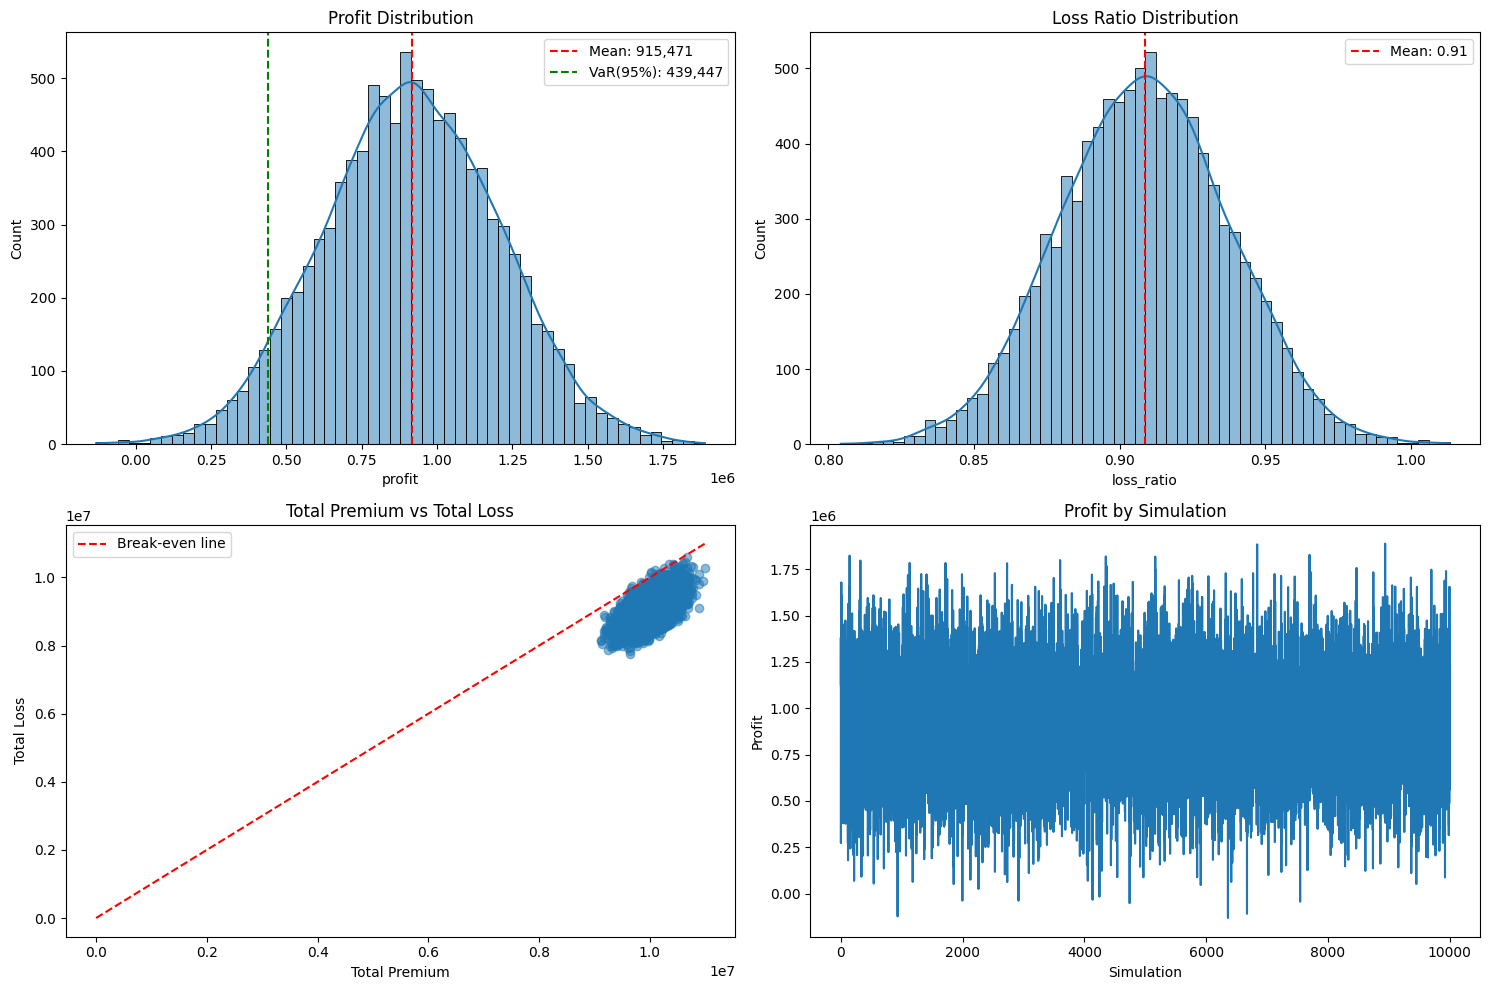


Portfolio Summary Statistics:
Average Profit: $915,471.17
Profit Standard Deviation: $290,073.48
Value at Risk (95%): $439,446.70
Average Loss Ratio: 90.86%
Probability of Loss: 0.09%

Comparing different loading factors...

Simulating with loading factor: 5.00%


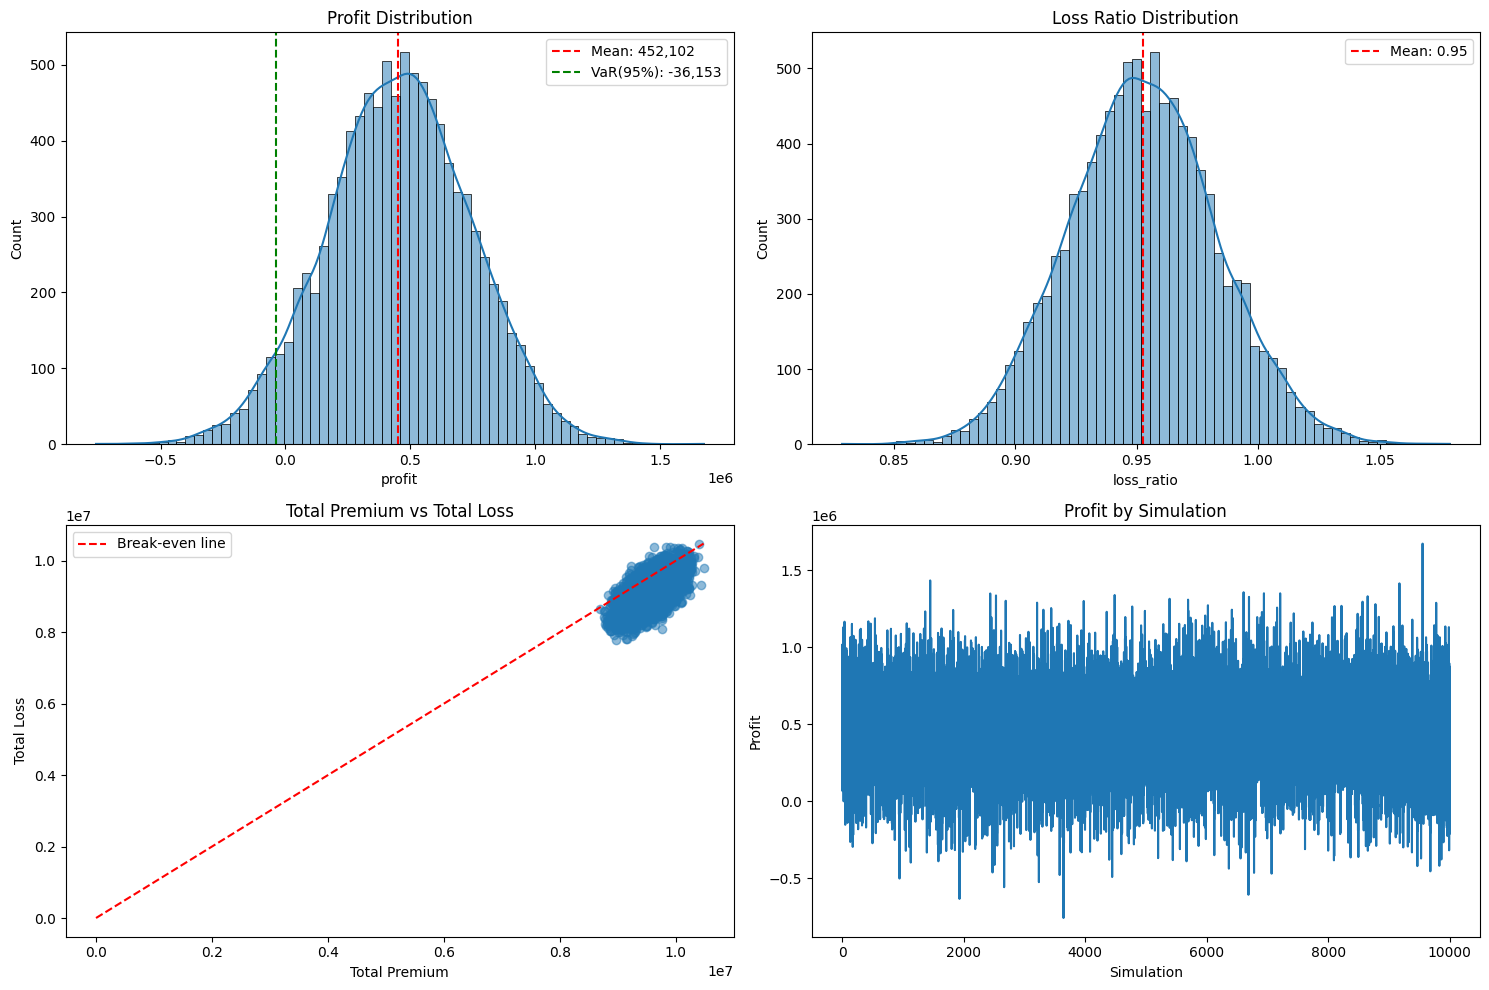


Portfolio Summary Statistics:
Average Profit: $452,102.13
Profit Standard Deviation: $289,536.44
Value at Risk (95%): $-36,152.73
Average Loss Ratio: 95.27%
Probability of Loss: 6.20%

Simulating with loading factor: 10.00%


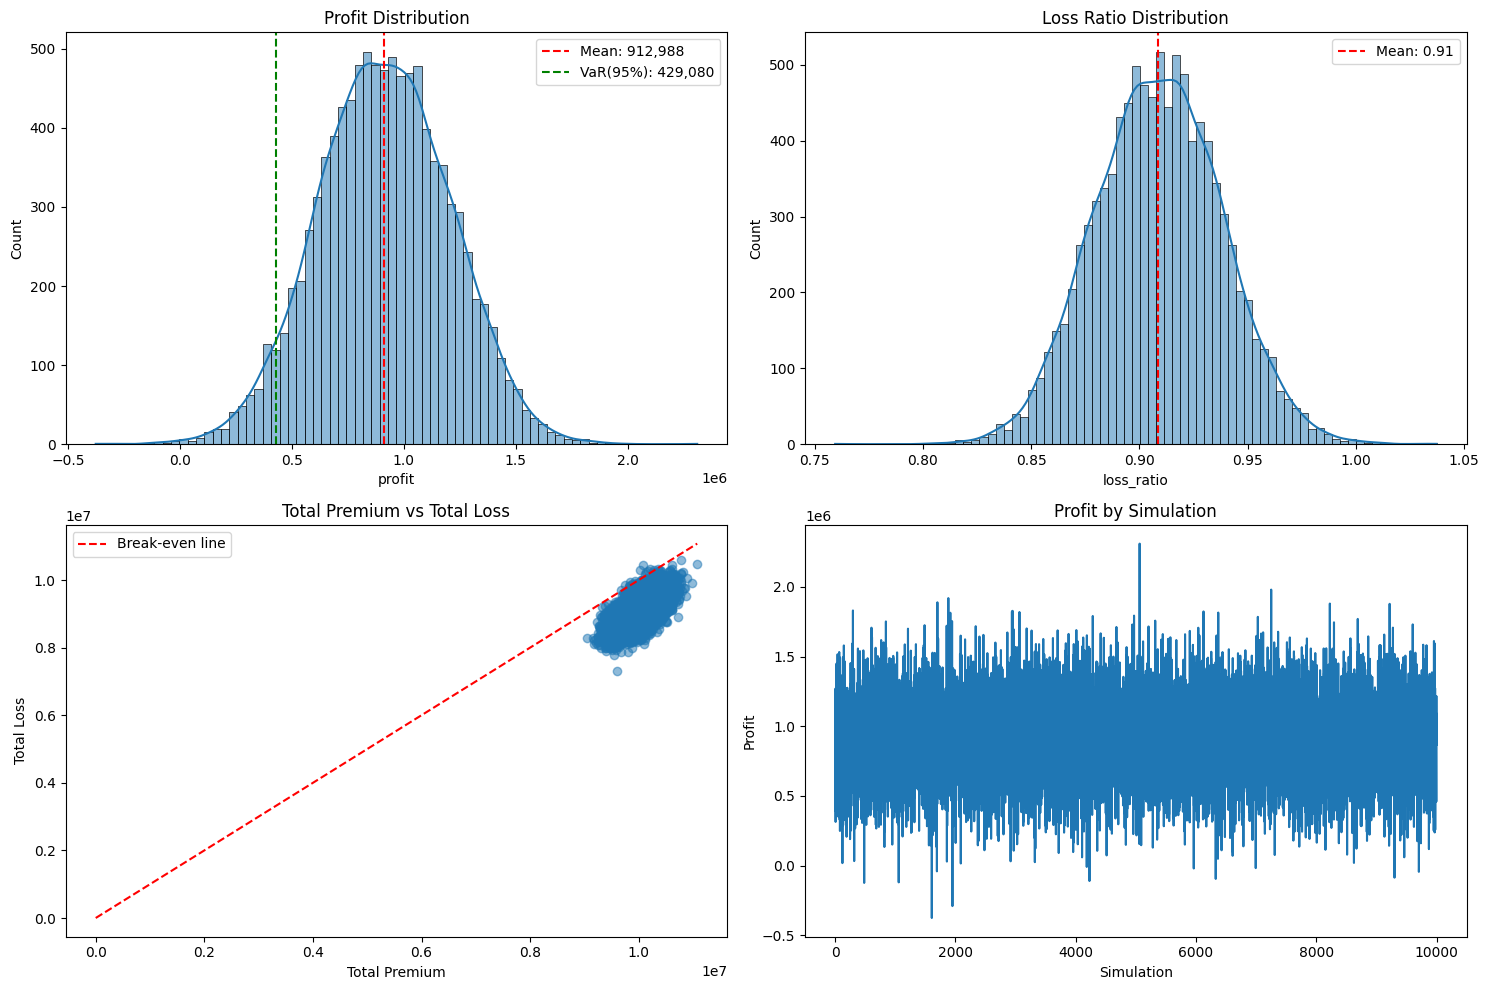


Portfolio Summary Statistics:
Average Profit: $912,987.94
Profit Standard Deviation: $293,529.38
Value at Risk (95%): $429,079.82
Average Loss Ratio: 90.88%
Probability of Loss: 0.13%

Simulating with loading factor: 15.00%


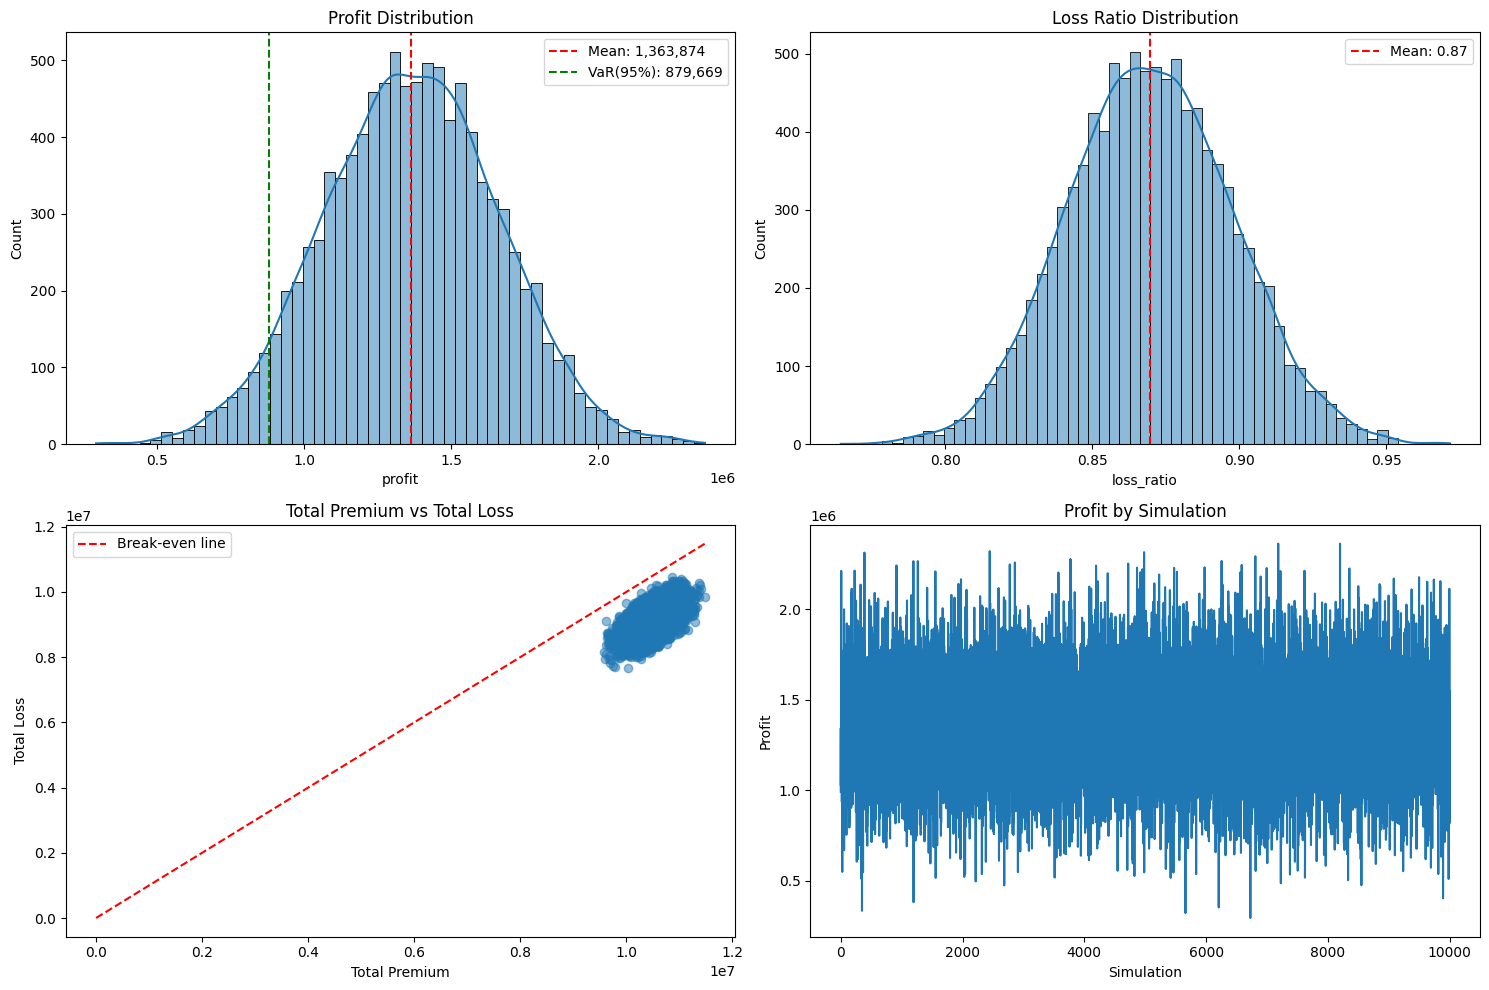


Portfolio Summary Statistics:
Average Profit: $1,363,874.16
Profit Standard Deviation: $294,483.83
Value at Risk (95%): $879,669.18
Average Loss Ratio: 86.97%
Probability of Loss: 0.00%

Simulating with loading factor: 20.00%


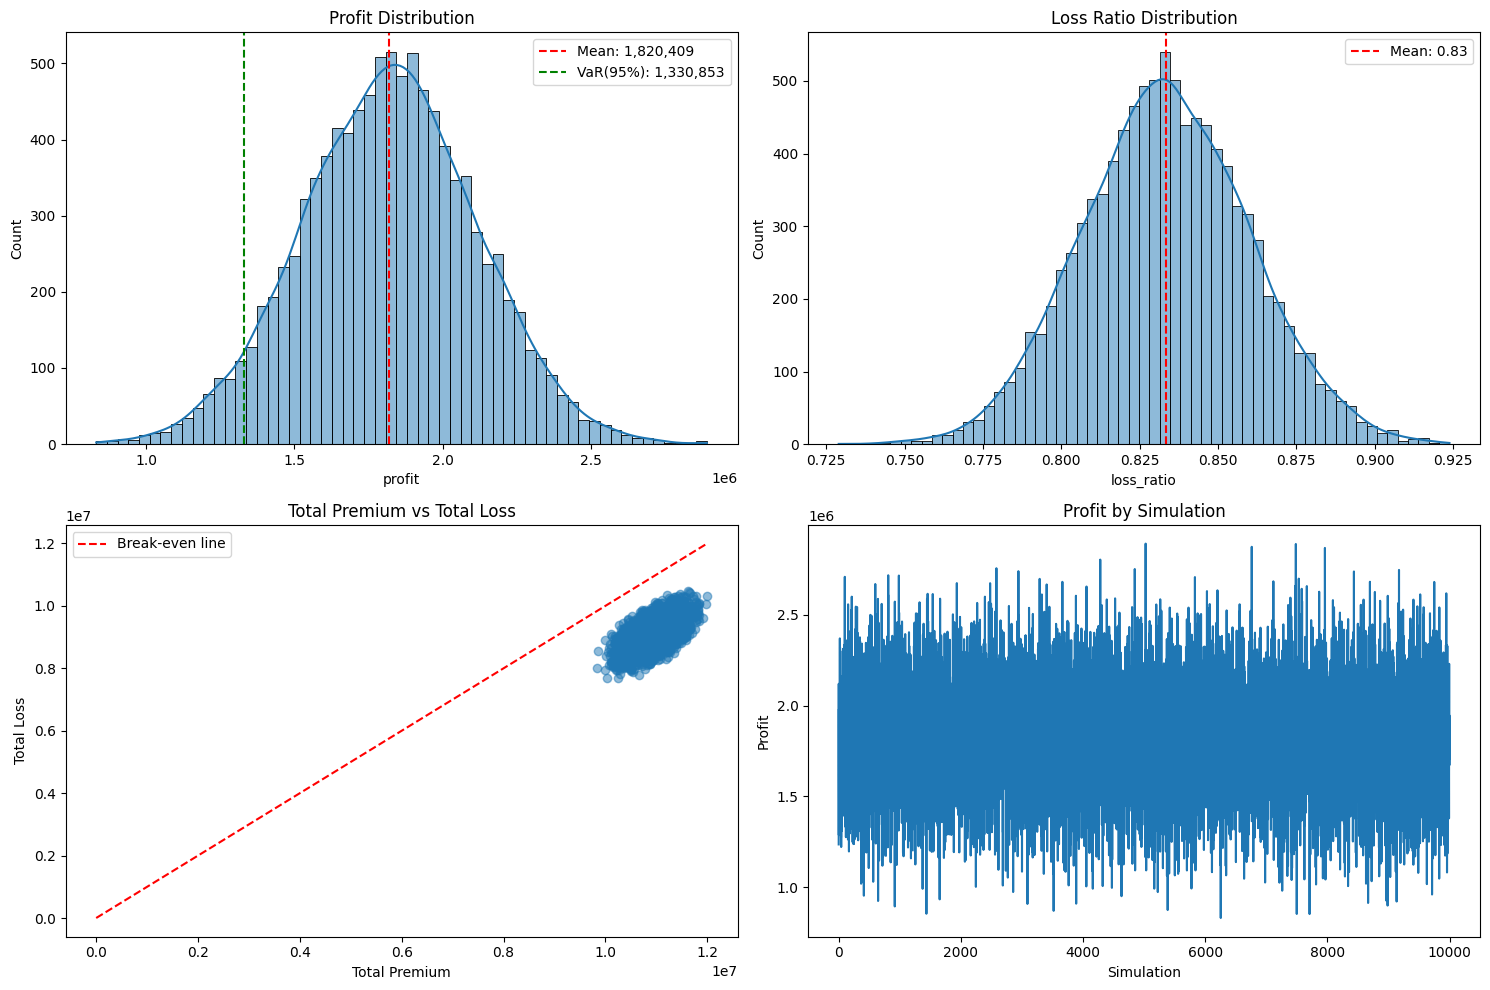


Portfolio Summary Statistics:
Average Profit: $1,820,409.16
Profit Standard Deviation: $294,407.33
Value at Risk (95%): $1,330,853.05
Average Loss Ratio: 83.33%
Probability of Loss: 0.00%

Simulating with loading factor: 25.00%


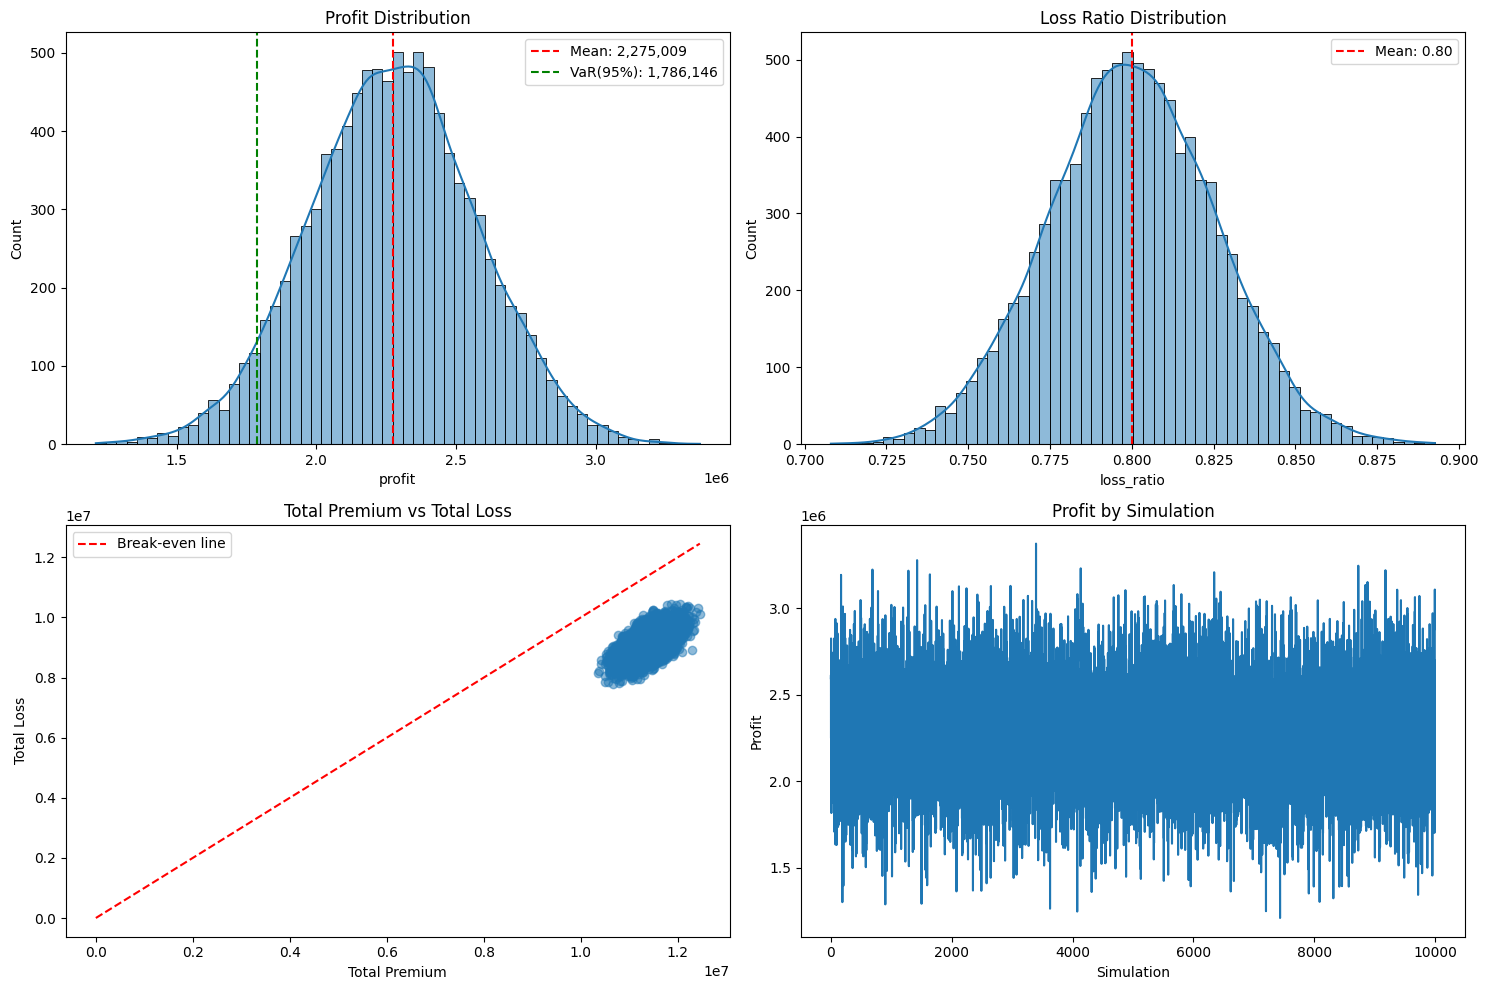


Portfolio Summary Statistics:
Average Profit: $2,275,009.28
Profit Standard Deviation: $297,688.25
Value at Risk (95%): $1,786,146.03
Average Loss Ratio: 80.00%
Probability of Loss: 0.00%

Loading Factor Comparison:
     avg_profit     profit_std        var_95  avg_loss_ratio  prob_loss  \
0  4.521021e+05  289536.440244 -3.615273e+04        0.952692     0.0620   
1  9.129879e+05  293529.383063  4.290798e+05        0.908797     0.0013   
2  1.363874e+06  294483.832684  8.796692e+05        0.869683     0.0000   
3  1.820409e+06  294407.328248  1.330853e+06        0.833337     0.0000   
4  2.275009e+06  297688.249061  1.786146e+06        0.800049     0.0000   

   loading_factor  
0            0.05  
1            0.10  
2            0.15  
3            0.20  
4            0.25  


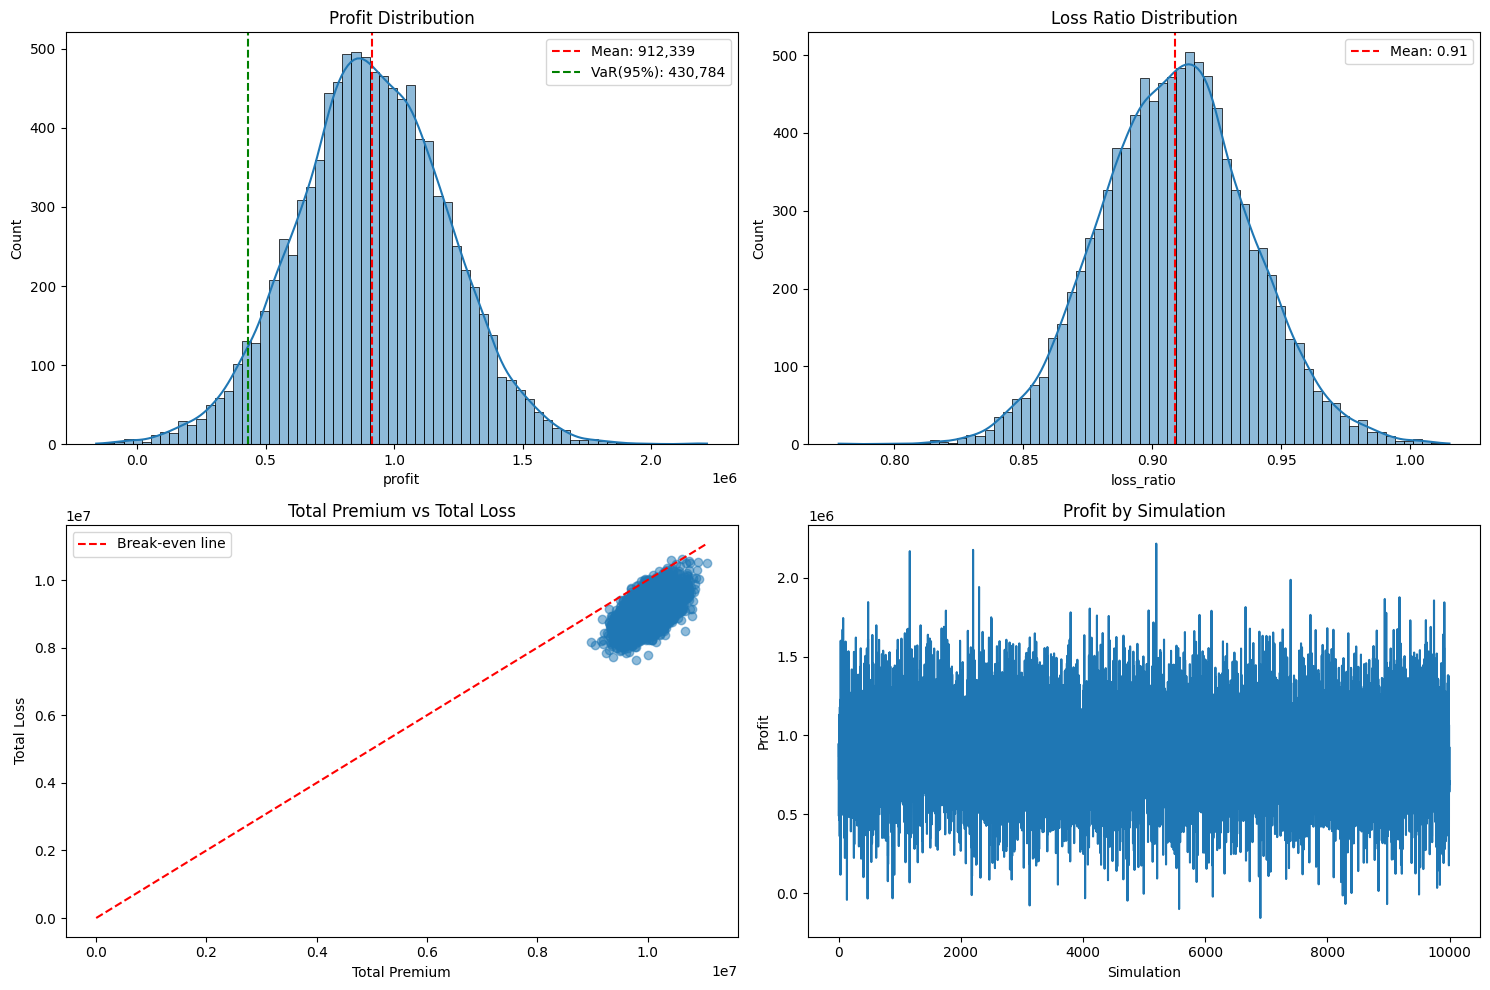


Portfolio Summary Statistics:
Average Profit: $912,338.53
Profit Standard Deviation: $290,555.35
Value at Risk (95%): $430,784.44
Average Loss Ratio: 90.88%
Probability of Loss: 0.16%

Simulating with loading factor: 5.00%


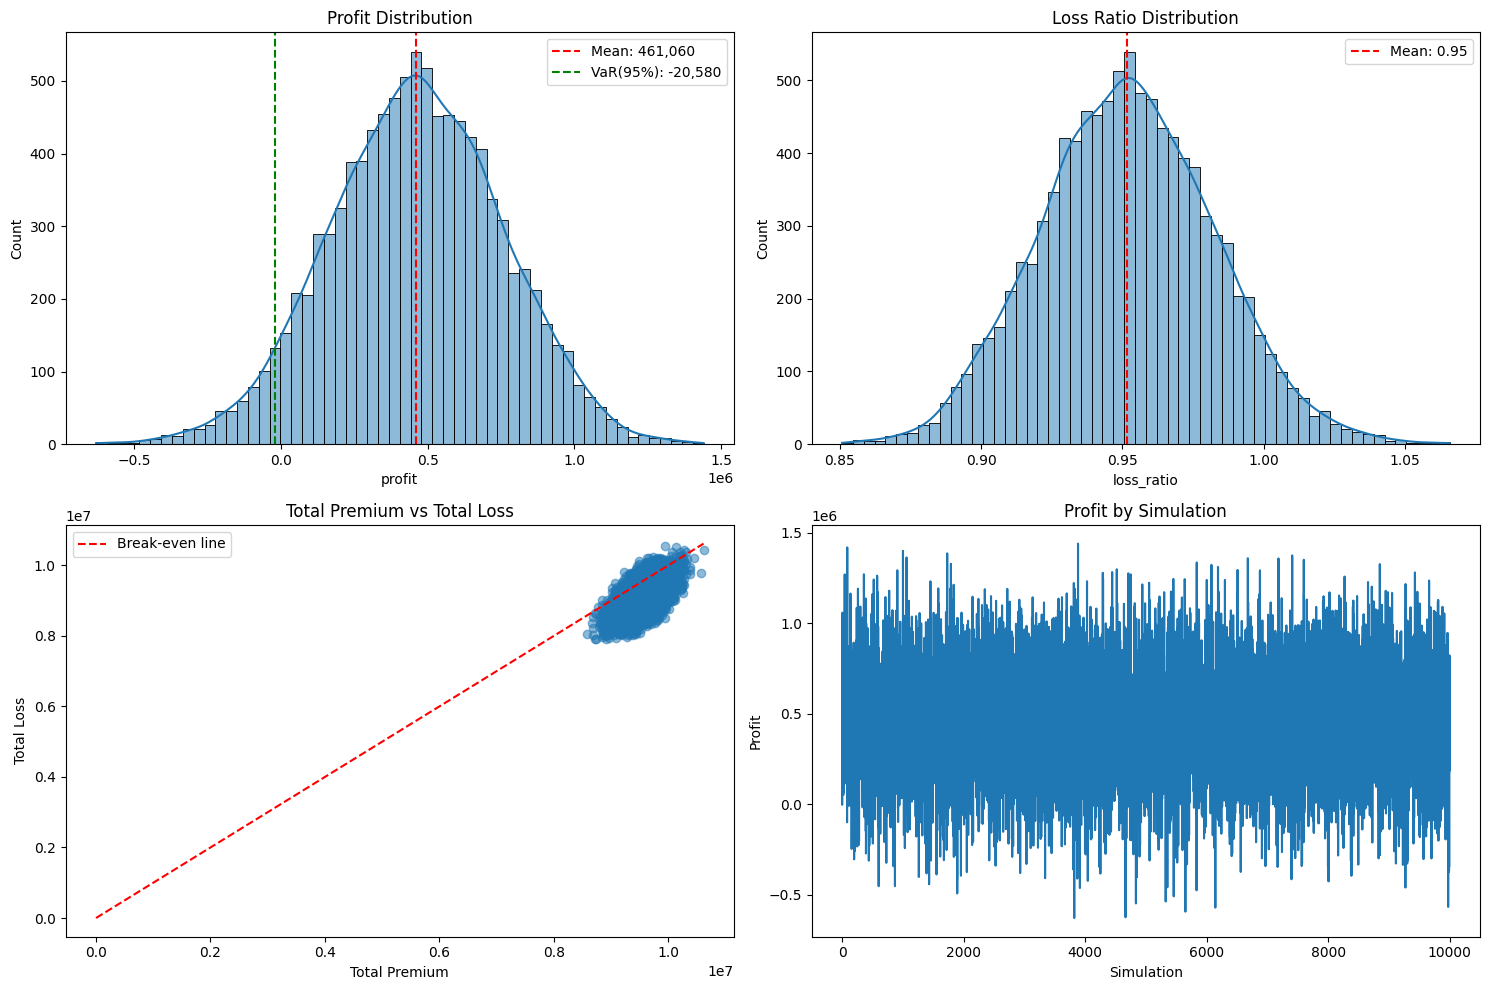


Portfolio Summary Statistics:
Average Profit: $461,059.73
Profit Standard Deviation: $292,874.07
Value at Risk (95%): $-20,580.46
Average Loss Ratio: 95.17%
Probability of Loss: 5.84%

Simulating with loading factor: 10.00%


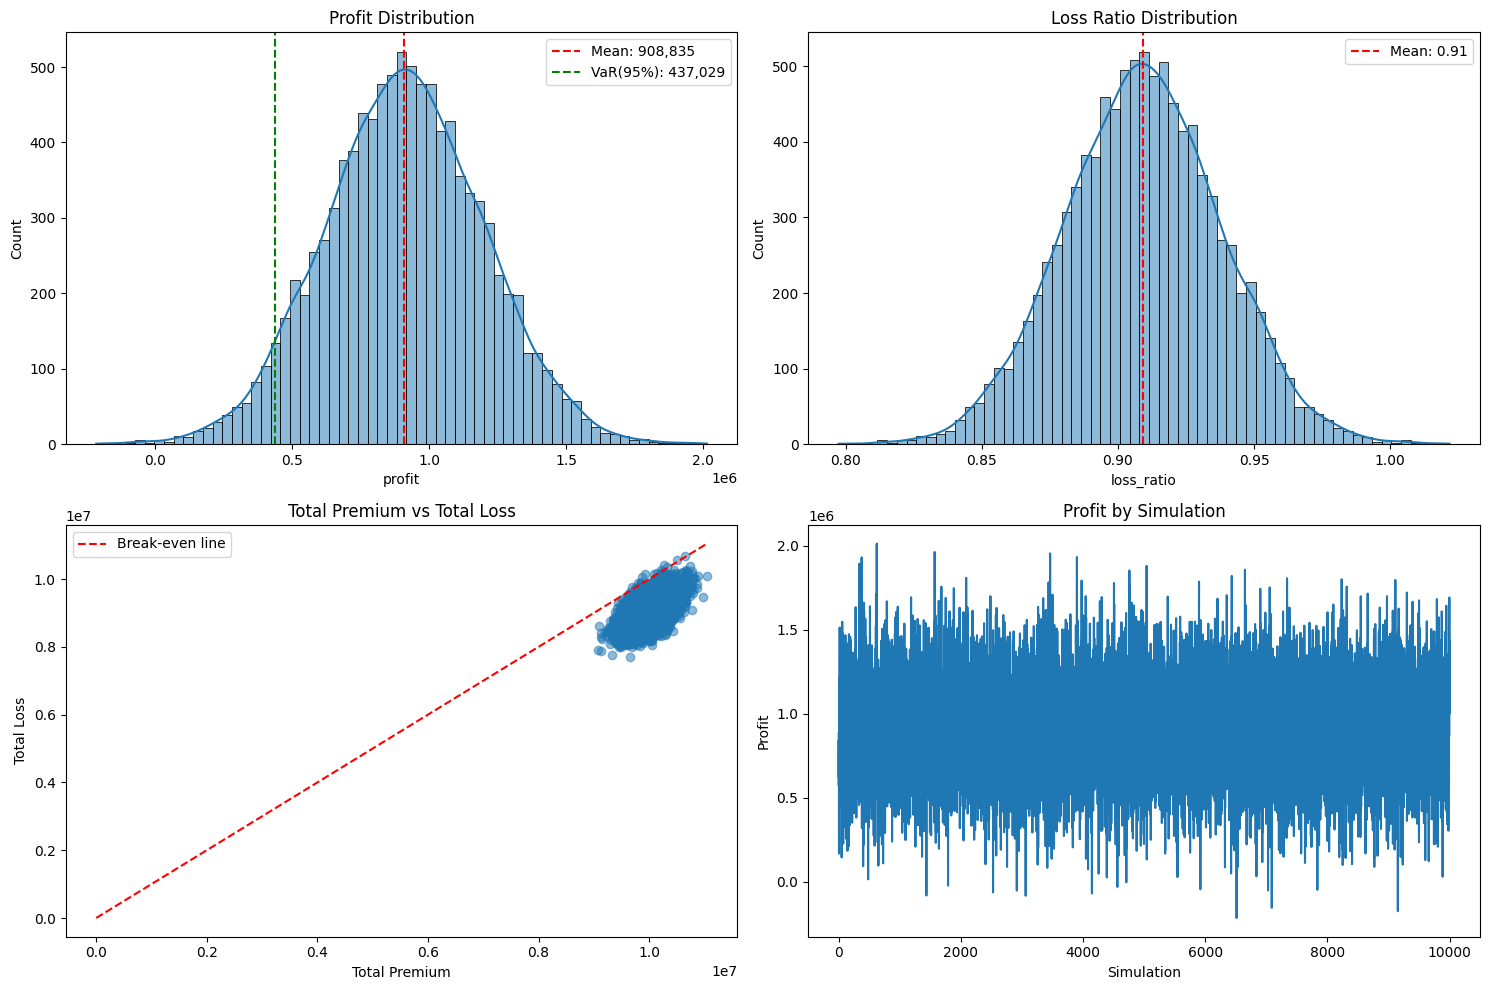


Portfolio Summary Statistics:
Average Profit: $908,834.51
Profit Standard Deviation: $288,841.91
Value at Risk (95%): $437,029.20
Average Loss Ratio: 90.92%
Probability of Loss: 0.14%

Simulating with loading factor: 15.00%


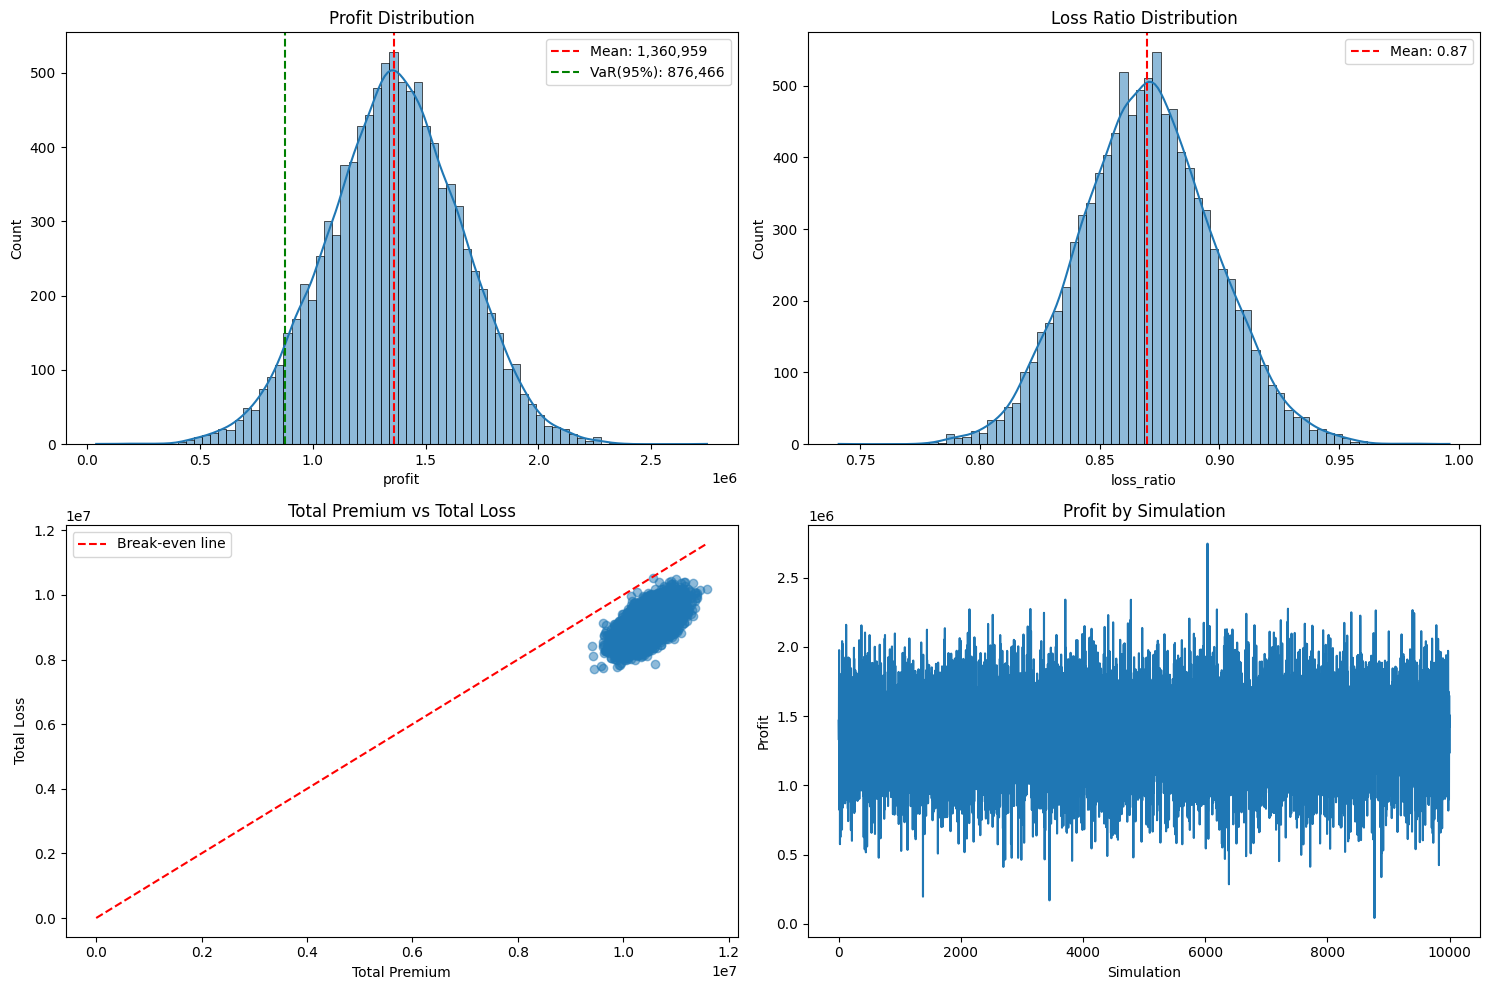


Portfolio Summary Statistics:
Average Profit: $1,360,958.75
Profit Standard Deviation: $294,058.80
Value at Risk (95%): $876,465.96
Average Loss Ratio: 87.00%
Probability of Loss: 0.00%

Simulating with loading factor: 20.00%


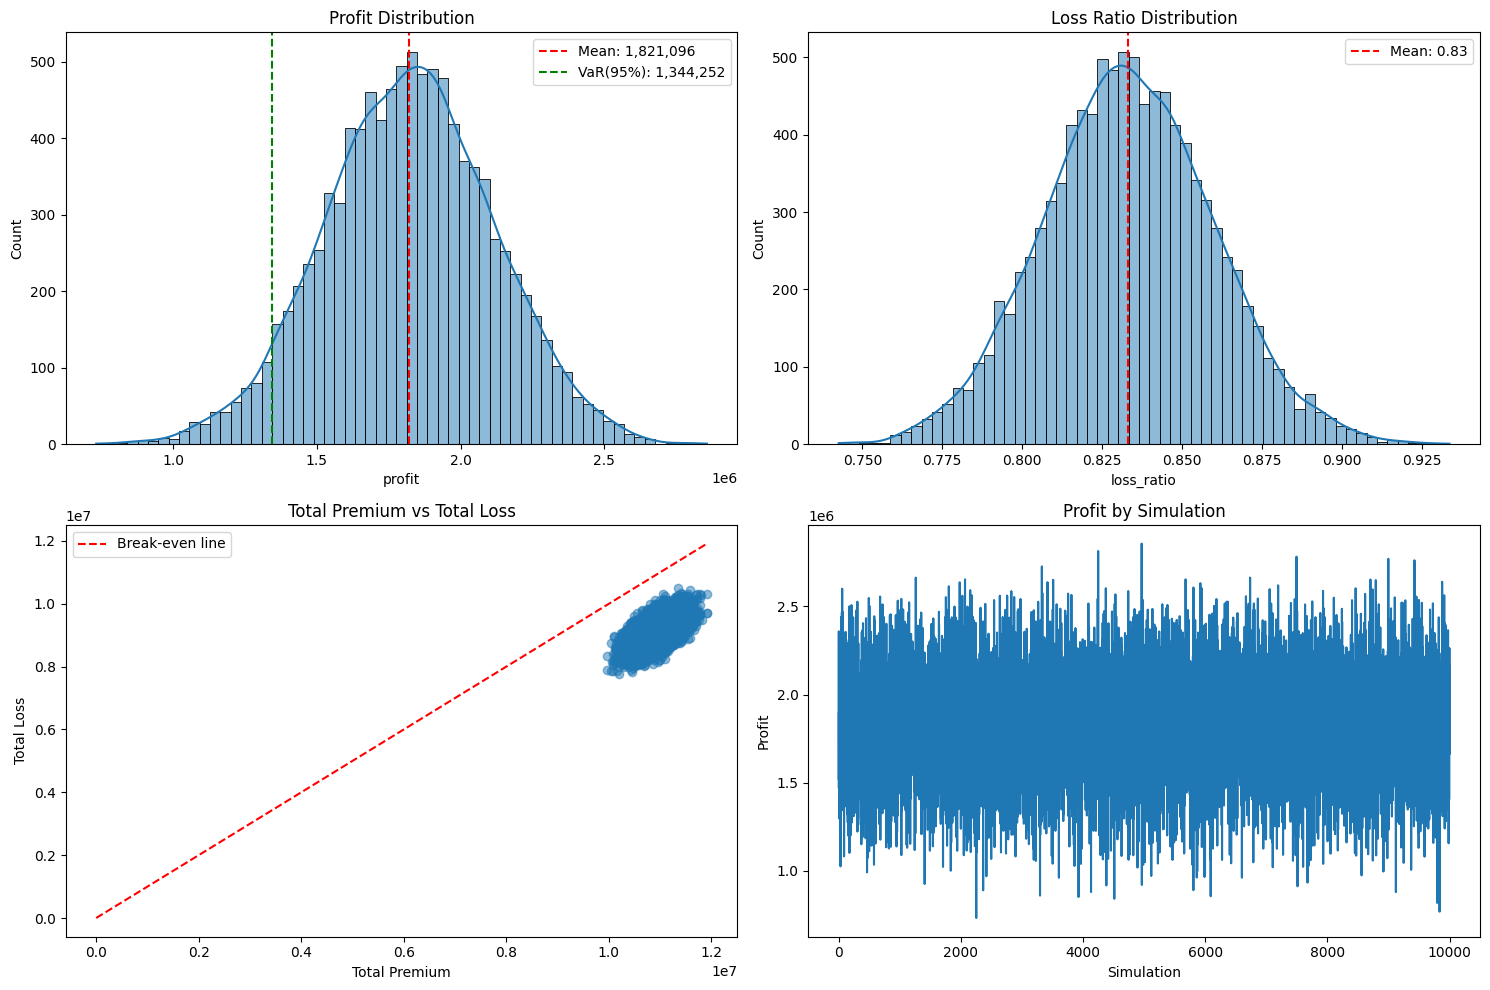


Portfolio Summary Statistics:
Average Profit: $1,821,095.58
Profit Standard Deviation: $292,156.33
Value at Risk (95%): $1,344,252.14
Average Loss Ratio: 83.32%
Probability of Loss: 0.00%

Simulating with loading factor: 25.00%


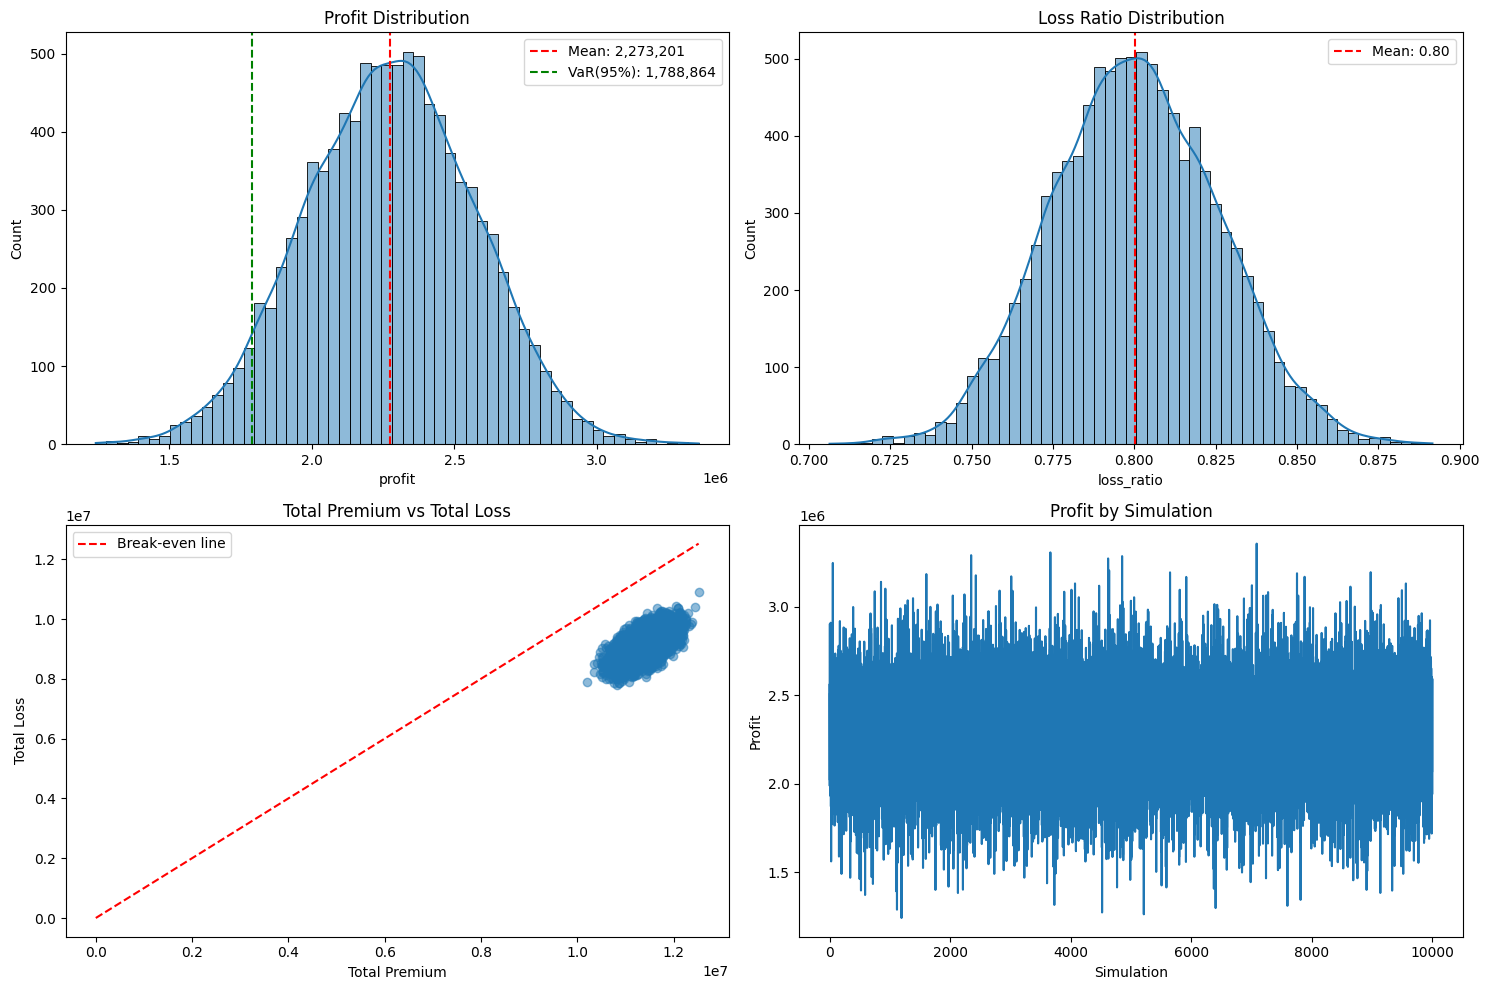


Portfolio Summary Statistics:
Average Profit: $2,273,200.60
Profit Standard Deviation: $295,504.54
Value at Risk (95%): $1,788,864.00
Average Loss Ratio: 80.02%
Probability of Loss: 0.00%


In [42]:
import numpy as np
from scipy.stats import poisson, gamma
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def simulate_insurance_portfolio(n_policies=1000, n_simulations=10000, loading_factor=0.1):
    # Parameters for different risk groups (5 pairs of lambda and gamma parameters)
    risk_groups = {
        'low_risk': {'lambda': 0.5, 'gamma_shape': 2.0, 'gamma_scale': 1000},
        'medium_low_risk': {'lambda': 1.0, 'gamma_shape': 2.2, 'gamma_scale': 1500},
        'medium_risk': {'lambda': 1.5, 'gamma_shape': 2.4, 'gamma_scale': 2000},
        'medium_high_risk': {'lambda': 2.0, 'gamma_shape': 2.6, 'gamma_scale': 2500},
        'high_risk': {'lambda': 2.5, 'gamma_shape': 2.8, 'gamma_scale': 3000}
    }
    
    # Calculate expected losses and premiums for each risk group
    premiums = {}
    for group, params in risk_groups.items():
        # Expected loss = E[N] * E[X]
        # E[N] = lambda (Poisson mean)
        # E[X] = gamma_shape * gamma_scale (Gamma mean)
        expected_loss = params['lambda'] * params['gamma_shape'] * params['gamma_scale']
        # Premium = expected_loss * (1 + loading_factor)
        premiums[group] = expected_loss * (1 + loading_factor)
    
    # Simulate portfolio results
    results = []
    for sim in range(n_simulations):
        total_premium = 0
        total_loss = 0
        
        # For each policy
        for _ in range(n_policies):
            # Randomly assign risk group
            risk_group = np.random.choice(list(risk_groups.keys()))
            params = risk_groups[risk_group]
            
            # Get premium for this risk group
            policy_premium = premiums[risk_group]
            total_premium += policy_premium
            
            # Simulate number of claims (Poisson)
            n_claims = poisson.rvs(params['lambda'])
            
            # Simulate claim sizes (Gamma) and sum them
            if n_claims > 0:
                claim_sizes = gamma.rvs(
                    a=params['gamma_shape'], 
                    scale=params['gamma_scale'], 
                    size=n_claims
                )
                policy_loss = np.sum(claim_sizes)
            else:
                policy_loss = 0
                
            total_loss += policy_loss
        
        # Calculate profit for this simulation
        profit = total_premium - total_loss
        results.append({
            'simulation': sim,
            'total_premium': total_premium,
            'total_loss': total_loss,
            'profit': profit,
            'loss_ratio': total_loss / total_premium if total_premium > 0 else np.inf
        })
    
    return pd.DataFrame(results)

def analyze_results(results_df):
    # Calculate key metrics
    avg_profit = results_df['profit'].mean()
    profit_std = results_df['profit'].std()
    var_95 = np.percentile(results_df['profit'], 5)
    avg_loss_ratio = results_df['loss_ratio'].mean()
    
    # Create visualization plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Profit distribution
    sns.histplot(data=results_df, x='profit', kde=True, ax=axes[0,0])
    axes[0,0].axvline(x=avg_profit, color='r', linestyle='--', label=f'Mean: {avg_profit:,.0f}')
    axes[0,0].axvline(x=var_95, color='g', linestyle='--', label=f'VaR(95%): {var_95:,.0f}')
    axes[0,0].set_title('Profit Distribution')
    axes[0,0].legend()
    
    # Loss ratio distribution
    sns.histplot(data=results_df, x='loss_ratio', kde=True, ax=axes[0,1])
    axes[0,1].axvline(x=avg_loss_ratio, color='r', linestyle='--', label=f'Mean: {avg_loss_ratio:.2f}')
    axes[0,1].set_title('Loss Ratio Distribution')
    axes[0,1].legend()
    
    # Premium vs Loss scatter
    axes[1,0].scatter(results_df['total_premium'], results_df['total_loss'], alpha=0.5)
    axes[1,0].plot([0, results_df['total_premium'].max()], [0, results_df['total_premium'].max()], 
                   'r--', label='Break-even line')
    axes[1,0].set_title('Total Premium vs Total Loss')
    axes[1,0].set_xlabel('Total Premium')
    axes[1,0].set_ylabel('Total Loss')
    axes[1,0].legend()
    
    # Profit over simulations
    axes[1,1].plot(results_df['simulation'], results_df['profit'])
    axes[1,1].set_title('Profit by Simulation')
    axes[1,1].set_xlabel('Simulation')
    axes[1,1].set_ylabel('Profit')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nPortfolio Summary Statistics:")
    print(f"Average Profit: ${avg_profit:,.2f}")
    print(f"Profit Standard Deviation: ${profit_std:,.2f}")
    print(f"Value at Risk (95%): ${var_95:,.2f}")
    print(f"Average Loss Ratio: {avg_loss_ratio:.2%}")
    print(f"Probability of Loss: {(results_df['profit'] < 0).mean():.2%}")
    
    return {
        'avg_profit': avg_profit,
        'profit_std': profit_std,
        'var_95': var_95,
        'avg_loss_ratio': avg_loss_ratio,
        'prob_loss': (results_df['profit'] < 0).mean()
    }

# Run simulation with different loading factors
def compare_loading_factors(loading_factors=[0.05, 0.1, 0.15, 0.2, 0.25]):
    results = []
    for lf in loading_factors:
        print(f"\nSimulating with loading factor: {lf:.2%}")
        df = simulate_insurance_portfolio(loading_factor=lf)
        metrics = analyze_results(df)
        metrics['loading_factor'] = lf
        results.append(metrics)
    
    return pd.DataFrame(results)

# Run the analysis
if __name__ == "__main__":
    # Run single simulation with default loading factor
    print("Running simulation with default loading factor (10%)...")
    results_df = simulate_insurance_portfolio()
    analyze_results(results_df)
    
    # Compare different loading factors
    print("\nComparing different loading factors...")
    loading_comparison = compare_loading_factors()
    print("\nLoading Factor Comparison:")
    print(loading_comparison)

# Run basic simulation
results_df = simulate_insurance_portfolio(
    n_policies=1000,      # number of policies
    n_simulations=10000,  # number of simulation runs
    loading_factor=0.1    # 10% loading factor
)
analyze_results(results_df)

# Compare different loading factors
loading_comparison = compare_loading_factors(
    loading_factors=[0.05, 0.1, 0.15, 0.2, 0.25]
)

In [ ]:
import numpy as np
from scipy.stats import poisson, gamma
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def simulate_insurance_portfolio(n_policies=5, n_simulations=1000, loading_factor=0.12):  # Increased loading factor
    # Adjusted parameters to achieve ~8-9% return
    risk_groups = {
        'low_risk': {'lambda': 0.4, 'gamma_shape': 2.0, 'gamma_scale': 900},        # Reduced risk
        'medium_low_risk': {'lambda': 0.8, 'gamma_shape': 2.2, 'gamma_scale': 1300},
        'medium_risk': {'lambda': 1.2, 'gamma_shape': 2.4, 'gamma_scale': 1700},
        'medium_high_risk': {'lambda': 1.6, 'gamma_shape': 2.6, 'gamma_scale': 2100},
        'high_risk': {'lambda': 2.0, 'gamma_shape': 2.8, 'gamma_scale': 2500}       # Reduced risk
    }
    
    # Pre-calculate premiums
    premiums = {group: params['lambda'] * params['gamma_shape'] * params['gamma_scale'] * (1 + loading_factor)
                for group, params in risk_groups.items()}
    
    risk_group_names = list(risk_groups.keys())
    
    results = []
    for sim in range(n_simulations):
        total_premium = 0
        total_loss = 0
        initial_capital = 0  # We'll calculate this based on premiums
        
        simulation_details = {
            'simulation': sim,
            'policies': []
        }
        
        for policy_idx in range(n_policies):
            risk_group = risk_group_names[policy_idx]
            params = risk_groups[risk_group]
            
            policy_premium = premiums[risk_group]
            total_premium += policy_premium
            
            n_claims = poisson.rvs(params['lambda'])
            policy_loss = 0
            
            if n_claims > 0:
                claims = gamma.rvs(a=params['gamma_shape'], 
                                 scale=params['gamma_scale'], 
                                 size=n_claims)
                policy_loss = claims.sum()
            
            total_loss += policy_loss
            
            simulation_details['policies'].append({
                'risk_group': risk_group,
                'premium': policy_premium,
                'n_claims': n_claims,
                'loss': policy_loss
            })
        
        # Calculate required capital as 3 times the expected annual premium
        initial_capital = total_premium * 3
        
        profit = total_premium - total_loss
        roi = (profit / initial_capital) * 100  # Return on Investment as percentage
        
        results.append({
            'simulation': sim,
            'total_premium': total_premium,
            'total_loss': total_loss,
            'initial_capital': initial_capital,
            'profit': profit,
            'roi': roi,
            'loss_ratio': total_loss / total_premium if total_premium > 0 else np.inf,
            'details': simulation_details
        })
    
    return pd.DataFrame(results)

def analyze_results(results_df):
    # Calculate key metrics
    avg_profit = results_df['profit'].mean()
    profit_std = results_df['profit'].std()
    var_95 = np.percentile(results_df['profit'], 5)
    avg_loss_ratio = results_df['loss_ratio'].mean()
    avg_roi = results_df['roi'].mean()
    
    # Create visualization plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # ROI distribution
    sns.histplot(data=results_df, x='roi', kde=True, ax=axes[0,0])
    axes[0,0].axvline(x=avg_roi, color='r', linestyle='--', label=f'Mean ROI: {avg_roi:.1f}%')
    axes[0,0].axvline(x=7, color='g', linestyle='--', label='Market Return (7%)')
    axes[0,0].set_title('Return on Investment Distribution')
    axes[0,0].legend()
    
    # Loss ratio distribution
    sns.histplot(data=results_df, x='loss_ratio', kde=True, ax=axes[0,1])
    axes[0,1].axvline(x=avg_loss_ratio, color='r', linestyle='--', label=f'Mean: {avg_loss_ratio:.2f}')
    axes[0,1].set_title('Loss Ratio Distribution')
    axes[0,1].legend()
    
    # Premium vs Loss scatter
    axes[1,0].scatter(results_df['total_premium'], results_df['total_loss'], alpha=0.5)
    axes[1,0].plot([0, results_df['total_premium'].max()], [0, results_df['total_premium'].max()], 
                   'r--', label='Break-even line')
    axes[1,0].set_title('Total Premium vs Total Loss')
    axes[1,0].set_xlabel('Total Premium')
    axes[1,0].set_ylabel('Total Loss')
    axes[1,0].legend()
    
    # ROI over simulations
    axes[1,1].plot(results_df['simulation'], results_df['roi'])
    axes[1,1].axhline(y=7, color='g', linestyle='--', label='Market Return (7%)')
    axes[1,1].set_title('ROI by Simulation')
    axes[1,1].set_xlabel('Simulation')
    axes[1,1].set_ylabel('ROI (%)')
    axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nPortfolio Summary Statistics:")
    print(f"Average Return on Investment: {avg_roi:.2f}%")
    print(f"Market Return: 7.00%")
    print(f"Outperformance: {avg_roi - 7:.2f}%")
    print(f"Average Profit: ${avg_profit:,.2f}")
    print(f"Profit Standard Deviation: ${profit_std:,.2f}")
    print(f"Value at Risk (95%): ${var_95:,.2f}")
    print(f"Average Loss Ratio: {avg_loss_ratio:.2%}")
    print(f"Probability of Loss: {(results_df['profit'] < 0).mean():.2%}")
    
    # Print first simulation details
    print("\nExample of first simulation details:")
    first_sim = results_df.iloc[0]
    print(f"\nInitial Capital Required: ${first_sim['initial_capital']:,.2f}")
    for policy in first_sim['details']['policies']:
        print(f"\nRisk Group: {policy['risk_group']}")
        print(f"Premium: ${policy['premium']:,.2f}")
        print(f"Number of Claims: {policy['n_claims']}")
        print(f"Total Loss: ${policy['loss']:,.2f}")
    
    return {
        'avg_roi': avg_roi,
        'avg_profit': avg_profit,
        'profit_std': profit_std,
        'var_95': var_95,
        'avg_loss_ratio': avg_loss_ratio,
        'prob_loss': (results_df['profit'] < 0).mean()
    }

# Run the analysis
if __name__ == "__main__":
    print("Running simulation with 5 policies...")
    results_df = simulate_insurance_portfolio()
    analyze_results(results_df)

### Convert the predicted probability to class based on the threshold tuning method value(0.0745), 

In [27]:
test_class=[1 if p>0.0745 else 0 for p in test_pred]

### Create result dataframe

In [28]:
res=pd.DataFrame({'policy_id':test['policy_id'],'is_claim':test_class})

In [29]:
res.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39063 entries, 0 to 39062
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   policy_id  39063 non-null  object
 1   is_claim   39063 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 610.5+ KB


In [30]:
res['is_claim'].value_counts()

is_claim
0    31286
1     7777
Name: count, dtype: int64

### Write the result dataframe to csv

In [31]:
res.to_csv("Random_Forest_Threshold_Tuning_Final.csv",index=False)